## Jupyter Extensions - convenience as an extension
For Jupyter to bring more added value I recommend you to install extensions
pip Commands:

pip install jupyter_nbextensions_configurator jupyter_contrib_nbextensions
jupyter contrib nbextension install --user
jupyter nbextensions_configurator enable --user

My Favorites are:
* Collapsible headings
* Code folding
* Notify
* Hinterland (can be nice, but I think I didn't come to use it correctly)
              
Thanks to https://becominghuman.ai/enhance-your-jupyter-experience-with-these-notebook-widgets-a2717921f678

In [1]:
# stretch the code to 90% of the browser width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Potential error messages

In [2]:
#Indexing errors, i.e. ValueError: Length of values (3519) does not match length of index (3529)
    #There are actually 3 data input:
    #1. The folder with all the stocks, 2. the benchmark (I tend to use QQQ), 3. the bond (I used TLT)
    #These errors are in my experience due to one or several of the input csvs do not cover the time span inserted in the "fromdate" / "todate" fields in globalparams, 
    #i.e. the todate goes to 2021 althogh the csvs only cover until mid 2020


## Downloading data from Yahoo
Enter symbol, from , to, path

In [3]:
r'''
import yahoofinance as yf
from csv import reader
# open file in read mode
with open(r'/home/mmd/Documents/nasdaq2017.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        # row variable is a list that represents a row in csv
        from1 = '2016-10-31'
        to = '2021-02-05'
        string = ''
        path = r'/home/mmd/Data/NASDAQ2017/'
        hist = yf.HistoricalPrices(string.join(row),  from1, to, frequency='1d')
        hist.to_csv(path + string.join(row) + '.csv')
'''

r'''
import yahoofinance as yf
#
row = "TLT"
from1 = '2005-10-31'
to = '2021-02-05'
string = ''
path = '/home/mmd/Data/'
hist = yf.HistoricalPrices(string.join(row),  from1, to, frequency='1d')
hist.to_csv(path + string.join(row) + '.csv')
'''

'\nimport yahoofinance as yf\n#\nrow = "TLT"\nfrom1 = \'2005-10-31\'\nto = \'2021-02-05\'\nstring = \'\'\npath = \'/home/mmd/Data/\'\nhist = yf.HistoricalPrices(string.join(row),  from1, to, frequency=\'1d\')\nhist.to_csv(path + string.join(row) + \'.csv\')\n'

## Imports

In [4]:
import datetime
import glob
import webbrowser
import os.path
import pandas as pd
import backtrader as bt
import backtrader.analyzers as btanal
import pyfolio as pf
import numpy as np
import sys
from scipy.stats import linregress
import quantstats as qs
import seaborn as sns
import optunity.metrics
import math
import cProfile
from time import time
import plotly.graph_objects as go
import multiprocess #can pickle when multiprocessing can't

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [20, 20]
#plt.rcParams['figure.dpi'] = 200

import warnings 
warnings.simplefilter(action='ignore', category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#Imports for walkforward analysis
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
import backtrader.indicators as btind
import datetime as dt
import pandas as pd
import pandas_datareader as web
from pandas import Series, DataFrame
import random
from copy import deepcopy
import optunity.metrics
import backtrader.analyzers as btanal

/home/mmd/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +
/home/mmd/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Parameters

In [5]:
globalparams = dict(path='/home/mmd/Data/NASDAQ2005/',      # location of your csv files, downloaded from Yahoo.
                    fromdate=datetime.datetime(2008, 2, 3),
                    todate=datetime.datetime(2020, 6, 2),
                    strategy="St",                          # HSt = Buy and Hold, St = Standard Strategy for non-survivorship free bias momentum                    
                    
                    # Momentum Strategy specifics(= St)        
                    mperiod=200,           # lookback period for momentum - default 90 periods
                    selcperc=2,            # number of stocks to select from the universe
                    time_interval="month", # if it is not "week" then it is month
                    time_between=1,        # time between time interval, e.g. 1 means weekly, 2 means every 2 weeks etc. same for months
                    
                    roc = True,        # Whether the rate of change should be taken into consideration
                    rocperiod=100,     # rate of change to make sure stock is increasing
                    
                    r_squared = False, # Whether volatility should be punished when calculating the momentum
                    
                    stoploss=False,     # Stop loss function (trailing stop loss) (probably is broken since rebalancing was reactivated)
                    stoplossperc=0.3,   # where to draw stop loss line
                    
                    ma = False,      # if stock price below moving average, the stock will not be considered
                    maperiod=75,     # moving average period
                    
                    rebal=True,            # apply proper rebalancing when stocks are sold than have a share above the equal weights
                    ranking_weights=False, # instead of equal weights use the rankings, hence a strong performer will be weighted higher
                    
                    ranking_stoploss = False,  # if the rankings drop in the last x days by more than y %, the stock will be sold
                    ranking_stoploss_d = 10,   # number of days that the maximum will be calculated from
                    ranking_stoploss_p = 0.1,  # percentage between the maximum and the last ranking. If the latter drops below, it will be sold
                    
                    #fundamental screening (needs data in form of pickle, search for 'pickle' in the code...)
                    fundamental=False, # switches on the fundamental screening
                    RG_years=3,        # how many years of revenue growth are relevant
                    RG_min=0.10,       # minimum revenue growth for RG indicator
                    indicator="RG",    # either  RG  (revenue growth) or PSG (Price/Sales Ratio divided by revenue growth (in % * 100)), 
                                       # P/S Data start for GOOG in 2015, hence when PSG is chosen, the fromdate has to be adjusted
                    
                    #General optimization parameters
                    params_combination= "23",               # 1: # of stocks picked from universe, 2: momentum period, 3: roc period
                    optimization_target="Sortino",          # Relevant for heatmap & optunity. 
                                                            # Potential Inputs: returns, Sharpe, Sortino, SQN (needs more than 30 trades!), VWR (variablility weighted returns)
                    heatmap_yaxisr=np.arange(1, 7, 3),      # y axis range of parameters for heatmap
                    heatmap_xaxisr=np.arange(100, 240, 20), # x axis (mperiod) range of parameters for heatmap
                    heatmap_zaxisr=np.arange(100, 250, 40), # z axis (ROC) range of parameters for 3d surfacemap                      
                    
                    #Heatmap section
                    heatmap=False,  # Does not work with Hold and Buy, Multiprocessing only here implemented (works in normal and walkforward runs)                  
                    
                    #optimization with optunity (various algorithms e.g. Partical Swarm Optimization)
                    optunity=False, # Either optunity or heatmap, Multiprocessing not implemented
                    num_eval=50,    # how many evaluations optunity will try // also for Walk Forward Analysis                    
                    
                    #Walk-forward-analysis, either optunity or heatmap must be switched on
                    walk=False,
                    fixed_length=False, # by setting it False the training data will will grow over time, otherwise it will keep the size given under train_splits
                    n_splits=3,         # how many chunks the data should have
                    
                    cash=1000000,               # amount of initial captal      
                    commission=0.005,           # broker fee/ask/bid spread
                    reserve=0.05,               # % of cash that won't be spent due to otherwise canceled orders
                    printlog=True,
                    ranking_timeanalysis=False, # excel file with rankings of all stocks over time, only works in "normal" run (no heatmap/Walk-forward/optunity), 
                                                # if it doesn't work, shorten the time period in fromdate
                    )

## Function section
Momentum (with and without volatility correction) [thanks to Teddy Koker https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/] and heatmap for analysis of variable combinations and thanks to samwindham1 https://github.com/samwindham1/algo-trader/blob/master/backtest/util/analyzers.py

In [6]:
#Momentum + ROC + fundamental screening (revenue increases or P/S / revenue growth) + SMA on price
class MomentumEnhanced(bt.Indicator):
    lines = ('trend',)
    params = (('period', 190), ('rperiod', 200), ('years', 3), ('RG_min', 0.15), ('PSG_max', 1), ('unpickled_df', 1), ('maperiod', 50))
    
    def __init__(self):
        self.addminperiod(self.params.period)
        if globalparams["roc"]:
            self.roc = bt.ind.ROC(self.data, period=self.p.rperiod)
        if globalparams["ma"]:
            self.MA = bt.ind.EMA(self.data, period=self.p.maperiod)
            self.crossover = bt.ind.CrossOver(self.data, self.MA) 
                
    def next(self):
        #fundamental screening
        if globalparams["fundamental"]:
            one = self.p.unpickled_df[(self.p.unpickled_df.indicator == "revenue") & (self.p.unpickled_df.ticker == self.data._name) & (self.p.unpickled_df.date < np.datetime64(self.data.datetime.date(0)))]
            growth = round(((one['value'].iloc[0:4].sum() / one['value'].iloc[self.p.years*4:self.p.years*4 + 4].sum())**(1/float(self.p.years))-1)*100,2)
            
            if globalparams["indicator"] == "PSG":
                ps = self.p.unpickled_df[(self.p.unpickled_df.indicator == "PS") & (self.p.unpickled_df.ticker == self.data._name) & (self.p.unpickled_df.date < np.datetime64(self.data.datetime.date(0)))]
                if growth <= 0:
                    growth = 0.00000001
                psg = ps[ps.date==ps.date.max()]["value"].iloc[0] / growth
                if psg > self.p.PSG_max:
                    psg = 1
                else:
                    psg = 0
            
            if growth > self.p.RG_min:
                growth = 0
            else:
                growth = 1
        
        #stop loss applied on momentum et al rankings
        rsl = 1
        if globalparams["ranking_stoploss"]:
            #for the first x days there is no ranking that can be used, hence catch errors here
            try:
                rank_len = len(self.lines.trend.get(ago=-1, size=globalparams["ranking_stoploss_d"]))
            except:
                rank_len = 1

            if rank_len > globalparams["ranking_stoploss_d"]-1:
                ranking_SL = max(self.lines.trend.get(ago=-1, size=globalparams["ranking_stoploss_d"])) * (1-globalparams["ranking_stoploss_p"])

                if self.lines.trend.get(ago=-1, size=1)[0] < ranking_SL and ranking_SL != "nan":
                    rsl = 0
                else:
                    rsl = 1
        
        #Momentum
        returns = np.log(self.data.get(size=self.p.period))
        x = np.arange(len(returns))
        slope, _, rvalue, _, _ = linregress(x, returns)
        momentum_annualized = (1 + slope) ** 252
        
        #ROC
        rocround = math.ceil(self.roc[0])
        roc_final = min(1, max(0, rocround)) if globalparams["roc"] else 1
        
        #Moving average on prices
        ma_final = (0 if self.crossover < 0 else 1) if globalparams["ma"] else 1
        
        #final line formula
        self.lines.trend[0] = momentum_annualized * roc_final * rsl * ma_final * (rvalue ** 2) / (1 if globalparams["r_squared"] else (rvalue ** 2)) * (1 if not globalparams["fundamental"] else (growth if globalparams["indicator"] == "RG" else psg))

                
# Great Heatmap to analyse different combinations of parameters
def my_heatmap1(data):
    data = np.array(data)
    xs = np.unique(data[:, 1].astype(int))
    ys = np.unique(data[:, 0].astype(int))
    vals = data[:, 2].reshape(len(ys), len(xs))
    
    #I tried to have texts in the heatmap cells to display more information...
    '''
    vals1 = data[:, 3].reshape(len(ys), len(xs))
    vals2 =[]
    for a_, b_ in zip(vals, vals1):
        for a1_, b1_ in zip(a_,b_):
            vals2.append(["{},{}".format(a1_, b1_)])
    '''
    min_val_ndx = np.unravel_index(np.argmin(vals, axis=None), vals.shape)
    max_val_ndx = np.unravel_index(np.argmax(vals, axis=None), vals.shape)
    
    cmap = LinearSegmentedColormap.from_list('', ['red', 'orange', 'yellow', 'chartreuse', 'limegreen'])
    ax = sns.heatmap(vals, xticklabels=xs, yticklabels=ys, cmap='viridis', annot=True, fmt='.2f')

    ax.add_patch(Rectangle(min_val_ndx[::-1], 1, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))
    ax.add_patch(Rectangle(max_val_ndx[::-1], 1, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))
    print("Average of all iterations", [sum(i)/len(i) for i in zip(*data)][2])
    #plt.tight_layout()
    
    plt.show()
    
def my_scatter_plot(data):
    # create data
    x = []
    y = []
    z = []
    for i in range(0, len(data)):
        x.append(data[i][1])
        y.append(data[i][0])
        z.append(round(data[i][3],0))
    '''
    # Change color with c and alpha. I map the color to the X axis value.
    sc = plt.scatter(x, y, s=z, c=z, cmap="viridis", alpha=0.4)
    plt.legend(*sc.legend_elements("sizes", num=6), loc=4)
    # Add titles (main and on axis)
    plt.xlabel("the X axis")
    plt.ylabel("the Y axis")
    plt.title("A colored bubble plot")
    '''
    df = pd.DataFrame(dict(x=x, y=y, z=z))
    sns.set_context("talk")
    #plt.figure(figsize=(10,6))
    pp=sns.scatterplot(x=x, 
                    y=y,
                    size=z,
                    sizes=(20,500),
                    alpha=0.5,
                    data=df)
    
    for line in range(0,df.shape[0]):
        pp.text(df.x[line]+0.2, df.y[line], df.z[line], horizontalalignment='left', size='medium', color='black')
    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
                      
    plt.show()

def plotly_4d(data):
    df1 = pd.DataFrame.from_records(data, columns=['selcperc', 'mperiod', 'rocperiod', 'value'])
    df = df1[~(df1['selcperc'].isin([2]))]
    df= df.pivot_table(index=['mperiod'], columns=['rocperiod'], values='value').reset_index()
    del df['mperiod']
    df.drop(df.index[0])
    print(df)
    fig = go.Figure(data=[go.Surface(z=df.values)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                      highlightcolor="limegreen", project_z=True))
    fig.update_layout(title_text="Analysis of Strategy", autosize=False, width=700, height=700,
                  margin=dict(l=65, r=50, b=65, t=90))
    fig.show() 
  
    
class Sortino(bt.Analyzer):
    params = (
        ('timeframe', bt.TimeFrame.Days),
        ('compression', 1),
        ('riskfreerate', 0.00),
        ('factor', None),
        ('convertrate', True),
        ('annualize', True),
    )

    RATEFACTORS = {
        bt.TimeFrame.Days: 252,
        bt.TimeFrame.Weeks: 52,
        bt.TimeFrame.Months: 12,
        bt.TimeFrame.Years: 1,
    }

    def __init__(self):
        super(Sortino, self).__init__()
        self.ret = btanal.TimeReturn(
            timeframe=self.p.timeframe,
            compression=self.p.compression)
        self.ratio = 0.0

    def stop(self):
        returns = list(self.ret.get_analysis().values())

        rate = self.p.riskfreerate

        factor = None
        if self.p.timeframe in self.RATEFACTORS:
            # Get the conversion factor from the default table
            factor = self.RATEFACTORS[self.p.timeframe]

        if factor is not None:
            # A factor was found
            if self.p.convertrate:
                # Standard: downgrade annual returns to timeframe factor
                rate = pow(1.0 + rate, 1.0 / factor) - 1.0
            else:
                # Else upgrade returns to yearly returns
                returns = [pow(1.0 + x, factor) - 1.0 for x in returns]

        if len(returns):
            # Sortino Ratio = (R - T) / TDD
            #   R = Avg Returns
            #   T = Target (risk-free rate)
            #   TDD = Downside Risk
            ret_free_avg = np.mean(returns) - rate
            tdd = math.sqrt(np.mean([min(0, r - rate)**2 for r in returns]))

            try:
                ratio = ret_free_avg / tdd

                if factor is not None and \
                        self.p.convertrate and self.p.annualize:

                    ratio = math.sqrt(factor) * ratio
            except (ValueError, TypeError, ZeroDivisionError):
                ratio = None

        else:
            # no returns
            ratio = None

        self.ratio = ratio

    def get_analysis(self):
        return dict(sortino=self.ratio)

# Picking optimization target and subsequent analyser functions for optimization
def opta(i):
    switcher={
            "VWR":['cerebro.addanalyzer(btanal.VWR, _name="VWR")','results1[0].analyzers.VWR.get_analysis()["vwr"]'],
            "Sortino":['cerebro.addanalyzer(Sortino, _name="sortino")','results1[0].analyzers.sortino.get_analysis()["sortino"]'],
            "returns":['1==1','cerebro.broker.getvalue()'], #TODO must be tested separately
            "Sharpe":['cerebro.addanalyzer(btanal.SharpeRatio, _name="sharpe")','results1[0].analyzers.sharpe.get_analysis()["sharperatio"]'],
            "SQN":['cerebro.addanalyzer(btanal.SQN, _name="sqn")','results1[0].analyzers.sqn.get_analysis()["sqn"]'],
         }
    return switcher.get(i,"Optimization Target not available")

def params_comb(i): 
    switcher={
            "12":[['globalparams["heatmap_yaxisr"]','globalparams["heatmap_xaxisr"]','[globalparams["rocperiod"],globalparams["rocperiod"]*1.0001]'],['results_list.append([i, j, k, PnL])','2','1','2']], #p1, p2, p3 in optunity maximize
            "13":[['globalparams["heatmap_yaxisr"]','[globalparams["mperiod"],globalparams["mperiod"]*1.0001]','globalparams["heatmap_zaxisr"]'],['results_list.append([i, k, j, PnL])','1','2','1']],
            "23":[['[globalparams["selcperc"],globalparams["selcperc"]*1.0001]','globalparams["heatmap_xaxisr"]','globalparams["heatmap_zaxisr"]'],['results_list.append([j, k, i, PnL])','0','0','1']],
            "123":[['globalparams["heatmap_yaxisr"]','globalparams["heatmap_xaxisr"]','globalparams["heatmap_zaxisr"]'],['results_list.append([i, j, k, PnL])','0','1','2']],
         }
    return switcher.get(i,"Optimization Target not available")

def params_comb_optunity(i): 
    switcher={
            "12":[['[globalparams["heatmap_yaxisr"][0],globalparams["heatmap_yaxisr"][-1]]','[globalparams["heatmap_xaxisr"][0],globalparams["heatmap_xaxisr"][-1]]','[globalparams["rocperiod"],globalparams["rocperiod"]*1.0001]'],['results_list.append([i, j, k, PnL])','0','1','2']], #p1, p2, p3 in optunity maximize
            "13":[['[globalparams["heatmap_yaxisr"][0],globalparams["heatmap_yaxisr"][-1]]','[globalparams["mperiod"],globalparams["mperiod"]*1.0001]','[globalparams["heatmap_zaxisr"][0],globalparams["heatmap_zaxisr"][-1]]'],['results_list.append([i, k, j, PnL])','0','2','1']],
            "23":[['[globalparams["selcperc"],globalparams["selcperc"]*1.0001]','[globalparams["heatmap_xaxisr"][0],globalparams["heatmap_xaxisr"][-1]]','[globalparams["heatmap_zaxisr"][0],globalparams["heatmap_zaxisr"][-1]]'],['results_list.append([j, k, i, PnL])','2','0','1']],
            "123":[['[globalparams["heatmap_yaxisr"][0],globalparams["heatmap_yaxisr"][-1]]','[globalparams["heatmap_xaxisr"][0],globalparams["heatmap_xaxisr"][-1]]','[globalparams["heatmap_zaxisr"][0],globalparams["heatmap_zaxisr"][-1]]'],['results_list.append([i, j, k, PnL])','0','1','2']],
         }
    return switcher.get(i,"Optimization Target not available")

## Simple Buy and Hold Strategy
Thanks to https://github.com/samuel281/qu-ant/blob/master/lib/strategies/hold_all_strategy.py

In [7]:
class HSt(bt.Strategy):
    params = dict(
        buy_date=datetime.datetime.today().isoformat(),
    )
    
    def __init__(self):
        self.stocks = self.datas[2:] #must filter out bond and spy 
                  
    def next(self):
        for d in self.stocks:
            if self.getposition(data=d).size:
                return
        
        if self.data.datetime.date(0).isoformat() < self.params.buy_date.isoformat(): #buydate must be determined by the first strategy, since it is the date of the first trade?
            return

        target_ratio = 1.0 - globalparams["reserve"]
        target_ratio_per_sec = target_ratio / len(self.stocks)            
        for d in self.stocks:
            self.order_target_percent(data=d, target=target_ratio_per_sec)            
    
    def log(self, arg):
        print('{} {}'.format(self.datetime.date(), arg))            
            
    def on_order_executed(self, order):
        pass
    
    
    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():

                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f} Broker {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash(), self.broker.getvalue()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} {} Price {:.2f} Value {:.2f} Size {} Broker {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size, self.broker.getvalue()))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
       

## Fill in gaps of survivorship bias free data

In [8]:
r'''
import pandas as pd
import glob, os, datetime
pathh = r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\data/'
idx = pd.date_range('2013-02-28', '2018-02-28')
for fname in glob.glob(os.path.join(pathh, '*')):
    df = pd.read_csv(fname, index_col=0, parse_dates=True)
    df1 = df.reindex(idx,fill_value=0)
    df1.to_csv(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\data2/' + os.path.basename(fname).replace(".csv", "") + '_1.csv')
    #print(df1)
    #break
'''   

'\nimport pandas as pd\nimport glob, os, datetime\npathh = r\'C:\\Users\\MMD\\PycharmProjects\\Trading\\Data Mining\\Data\\data/\'\nidx = pd.date_range(\'2013-02-28\', \'2018-02-28\')\nfor fname in glob.glob(os.path.join(pathh, \'*\')):\n    df = pd.read_csv(fname, index_col=0, parse_dates=True)\n    df1 = df.reindex(idx,fill_value=0)\n    df1.to_csv(r\'C:\\Users\\MMD\\PycharmProjects\\Trading\\Data Mining\\Data\\data2/\' + os.path.basename(fname).replace(".csv", "") + \'_1.csv\')\n    #print(df1)\n    #break\n'

## Survivor bias free momentum strategy
Thanks to 

In [9]:
class Sur(bt.Strategy):
    params = dict(
            selcperc=0.50,  # percentage of stocks to select from the universe
            rperiod=1,  # period for the returns calculation, default 1 period
            vperiod=55,  # lookback period for volatility - default 36 periods
            mperiod=155,  # lookback period for momentum - default 90 periods
            momentum=MomentumEnhanced, # parametrize the momentum and its period
            reserve=globalparams["reserve"],  # 5% reserve capital
            monthdays=[1],
            monthcarry=True,
            when=bt.timer.SESSION_START,
            benchmarkstop=False, # If true, no stocks will be bought and no rebalancing will be done if benchmark is below SMAperiod
            SMAperiod=200,
            benchmark_bond=True, # Sell all Stocks and buy Bonds
            jump_momentum=True, # If true, after a time of jump_one (30 days x jump_one) in every month, all the money will be directed to the best performing stock. Rule for that:
                                # In Excel, this is a 0.6 x month return of fund with best past 3 month return plus 0.4 x return of fund with best return, month to date.
            jump_one=0.6,
            printlog=True,
        )

    def __init__(self):
        self.bench = self.data0
        self.bond = self.data1
        self.stocks = self.datas[2:]
        # calculate 1st the amount of stocks that will be selected
        self.selnum = int(len(self.stocks) * self.p.selcperc)

        # allocation perc per stock
        # reserve kept to make sure orders are not rejected due to
        # margin. Prices are calculated when known (close), but orders can only
        # be executed next day (opening price). Price can gap upwards
        self.perctarget = (1.0 - self.p.reserve) / self.selnum
        
        # This is the set up of the timer that makes the strategy being executed at the given time
        self.add_timer(
            when=self.p.when,
            monthdays=self.p.monthdays,
            monthcarry=self.p.monthcarry
        )
        
        self.stocks_len = []
        
        jump = True

        # returns, volatilities and momentums
        rs = [bt.ind.PctChange(d, period=self.p.rperiod) for d in self.stocks]
        vs = [bt.ind.StdDev(ret, period=self.p.vperiod) for ret in rs]
        #ms = [bt.ind.ROC(d, period=self.p.mperiod) for d in self.datas]
        ms = [self.p.momentum(d, period=self.p.mperiod) for d in self.stocks]
        
        self.bench_sma = bt.ind.SMA(self.data0, period=self.p.SMAperiod)
        
        # simple rank formula: (momentum * net payout) / volatility
        # the highest ranked: low vol, large momentum, large payout
        self.ranks = {d: m / v for d, v, m in zip(self.stocks, vs, ms)}
        #TODO: does it perform better without the volatility?

        self.bench_filter = self.bench < self.bench_sma


    def log(self, arg):
        if self.p.printlog:
            print('{} {}'.format(self.datetime.date(), arg))
        
    # This section is for logging of orders in greater detail to figure out whether the strategy is actually having no problem with orders
    '''
    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():
            
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))


        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
    '''       
    
    # This is the function using the timer to execute the rebalance 
    def notify_timer(self, timer, when, *args, **kwargs):
        print('strategy notify_timer with tid {}, when {} _getminperstatus {}'.
              format(timer.p.tid, when, int(self._getminperstatus())))
        print("timer")
        if self._getminperstatus() < 0:
            self.rebalance()
    
    def nextstart(self):
        self.ranks_filter = self.ranks
        print("nextstart")
        self.next()
        
    def prenext(self):
        self.stocks_len = [d for d in self.stocks if len(d)]
        self.ranks_filter = dict(zip(self.stocks_len, [self.ranks[k] for k in self.stocks_len]))        
        self.next()
        
    def next(self):
        print("next")
        pass # must be filled with a pass

    
    # Actual order giving by a ranking takes place here
    def rebalance(self):
        print("rebalance")
        #if jump == True:
        # Enter Jump Code here    
        
        # sort data and current rank
        ranks = sorted(
            self.ranks_filter.items(),  # get the (d, rank), pair
            key=lambda x: x[1][0],  # use rank (elem 1) and current time "0"
            reverse=True,  # highest ranked 1st ... please
        )
        
        # put top ranked in dict with data as key to test for presence
        rtop = dict(ranks[:self.selnum])

        # For logging purposes of stocks leaving the portfolio
        rbot = dict(ranks[self.selnum:])

        # prepare quick lookup list of stocks currently holding a position
        posdata = [d for d, pos in self.getpositions().items() if pos]
        

        if self.p.benchmarkstop:
            for d in (d for d in posdata):
                if "Bond" == d._name and self.bench_filter:
                    return
                else:
                    if "Bond" == d._name and not self.bench_filter:
                        self.order_target_percent("Bond", target=0.0)
                        self.log('Leave {} due to end of down period'.format(d._name))
                        return
        
        # Triple Momentum: If Benchmark index is below SMA, nothing will be bought or rebalanced
        if self.p.benchmarkstop:
            if self.bench_filter:
                #print('SMA {} - Bench {}'.format(self.bench_sma[0], self.bench[0]))
                if self.p.benchmark_bond:
                    for d in posdata:
                        self.log('Leave {} due to switch to Bonds'.format(d._name))
                        self.order_target_percent(d, target=0.0)
                    self.order_target_percent("Bond", target=0.95)
                    self.log('Buy Bond')
                    bond_flag = True
                    return #Code stops here and skips rebalancing und buying

        # remove those no longer top ranked
        # do this first to issue sell orders and free cash
        for d in (d for d in posdata if d not in rtop):
            self.log('Leave {} - Rank {:.2f}'.format(d._name, rbot[d][0]))
            self.order_target_percent(d, target=0.0)
        
        # rebalance those already top ranked and still there
        for d in (d for d in posdata if d in rtop):
            self.log('Rebal {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)
            del rtop[d]  # remove it, to simplify next iteration

        # issue a target order for the newly top ranked stocks
        # do this last, as this will generate buy orders consuming cash
        for d in rtop:
            self.log('Enter {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)
            
    def stop(self):
        pnl = round(self.broker.getvalue() - globalparams["cash"],2)
        print('Final PnL: {}'.format(
            pnl))

## Momentum Strategy
Originally it is a combination of the momentum strategy example given on the official website:
https://www.backtrader.com/blog/2019-05-20-momentum-strategy/momentum-strategy/
and  https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/
Changes have been made:
* Triple momentum, i.e. if benmarkstop is True, benchmark index is below SMAperiod no stocks will be bought anymore. 
If benchmark_bond is True all stocks will be sold and bond of choice will be bought
* Sizer has been adapted to equal distribution of free cash and not equal share among all stocks
* 

In [10]:
class St(bt.Strategy):
    params = dict(
        selcperc=globalparams["selcperc"],  # percentage of stocks to select from the universe
        mperiod=globalparams["mperiod"],  # lookback period for momentum - default 90 periods
        rocperiod=globalparams["rocperiod"],   # rate of change to make sure stock is increasing
        maperiod=globalparams["maperiod"],  # lookback period for momentum - default 90 periods
        momentumplus=MomentumEnhanced, # choose which momentum function is used
        reserve=globalparams["reserve"],  # 5% reserve capital
        monthdays=[1],
        monthcarry=True,
        weekdays=[5],
        weekcarry=True,
        benchmarkstop=False, # If true, no stocks will be bought and no rebalancing will be done if benchmark is below SMAperiod / Must be switched off in WFA
        SMAperiod=100,
        benchmark_bond=True, # Sell all Stocks and buy Bonds
        jump_momentum=True, # If true, after a time of jump_one (30 days x jump_one) in every month, all the money will be directed to the best performing stock. Rule for that:
                            # In Excel, this is a 0.6 x month return of fund with best past 3 month return plus 0.4 x return of fund with best return, month to date.
        jump_one=0.6,
        printlog=globalparams["printlog"],
        WFA=False,          #Switch for the last "putting the fragments together run" of the Walk Forward Analysis
        start_dates=None,  # Starting days for trading periods (a list)
        end_dates=None,
        stoploss=globalparams["stoploss"],   #activate stop loss
        stop_loss=globalparams["stoplossperc"],  # price is 10% less than the entry point
        trail=True,
        
    )

    def __init__(self):
        self.bench = self.data0
        self.bond = self.data1
        self.stocks = self.datas[2:]
        # calculate 1st the amount of stocks that will be selected
        
        self.stoplossorders = {}
        if globalparams["fundamental"]:
            df_pickle1 = pd.read_pickle("/home/mmd/Downloads/BIG.pkl") #if read_pickle gives you some error with "_data" then pip install pandas -U 
            #data in dropbox, thx to RomanKoshkin: https://github.com/RomanKoshkin/StockScraperMacroTrends2
            df_pickle = df_pickle1[(df_pickle1.indicator == "revenue") | (df_pickle1.indicator == "PS")]
            list_stocks = []
            for d in self.stocks:
                list_stocks.append(d._name)
            #df_pickle["index"] = df_pickle['indicator'] + df_pickle['ticker'] + df_pickle['date'].astype(str)
            #df_pickle.set_index('date', inplace=True)
            df_pickle.drop(["comp_name", "industry"], axis=1, inplace=True)
            df_pickle1 = df_pickle[df_pickle.ticker.isin(list_stocks)]
            df_pickle1.sort_values(['indicator', 'ticker', 'date'], ascending=[True, True, False])
            #print(df_pickle.to_dict())
            self.unpickled_df = df_pickle1

        # counter for time in between
        self.timer_i = 0
        self.posdata =[]
        
        # This is the set up of the timer that makes the strategy being executed at the given time
        if globalparams["time_interval"] == "week":
            self.add_timer(
                when=bt.timer.SESSION_START,
                weekdays=self.p.weekdays,
                weekcarry=self.p.weekcarry,
            )  
        else:
            self.add_timer(
                when=bt.timer.SESSION_START,
                monthdays=self.p.monthdays,
                monthcarry=self.p.monthcarry,
            )

        # preparation for Walk Forward Analysis
        if self.p.WFA == True:
            self.mperiod = dict()
            self.vperiod = dict()
            self.ms = dict()
            self.selnum = dict()

            self.date_combos = [c for c in zip(self.p.start_dates, self.p.end_dates)]

            # Additional indexing, allowing for differing start/end dates
            for sd, ed, f, s, t in zip(self.p.start_dates, self.p.end_dates, self.p.mperiod, self.p.rocperiod, self.p.selcperc):
                self.selnum[(sd, ed)] = int(t) # of stocks bought
                
                # returns, volatilities and momentums
                self.ms[(sd, ed)] = [self.p.momentumplus(d, period=int(f), rperiod=int(s)) for d in self.stocks] #toDo how to implement it with two parameters
        
        #Non walk forward analysis
        else:
            self.selnum = int(self.p.selcperc)
            # allocation perc per stock
            #momentums
            if globalparams["fundamental"]:
                ms = [self.p.momentumplus(d,period=int(self.p.mperiod), rperiod=int(self.p.rocperiod), maperiod=int(self.p.maperiod), unpickled_df=self.unpickled_df) for d in self.stocks]
            else:
                ms = [self.p.momentumplus(d,period=int(self.p.mperiod), rperiod=int(self.p.rocperiod), maperiod=int(self.p.maperiod)) for d in self.stocks]
            self.bench_sma = bt.ind.SMA(self.data0, period=self.p.SMAperiod)

            # simple rank formula: (momentum * net payout) / volatility
            # the highest ranked: low vol, large momentum, large payout
            self.ranks = {d: m for d, m in zip(self.stocks, ms)}
            
            self.bench_filter = self.bench < self.bench_sma
                
    def log(self, arg):
        if self.p.printlog:
            print('{} {}'.format(self.datetime.date(), arg))
        
    # This section is for logging of orders in greater detail to figure out whether the strategy is actually having no problem with orders
    
    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():
            
                dt, dn = self.datetime.date(), order.data._name
                self.log('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                self.log('Sell {} {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                self.log('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))
                
                if self.p.stoploss:
                    if not self.p.trail:
                        stop_price = order.executed.price * (1.0 - self.p.stop_loss)
                        storder = self.sell(data=order.data, exectype=bt.Order.Stop, price=stop_price, size=order.executed.size)
                        self.stoplossorders[order.data._name] = storder
                    else:
                        storder = self.sell(data=order.data, exectype=bt.Order.StopTrail, trailpercent=self.p.stop_loss, size=order.executed.size)
                        self.stoplossorders[order.data._name] = storder

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                self.log('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.price*order.executed.size, order.executed.size))
                if self.p.stoploss:
                    del self.stoplossorders[order.data._name]
                    for d in (d for d in self.posdata if d in [order.data]):
                        self.posdata.remove(d)  

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
           
    
    # This is the function using the timer to execute the rebalance 
    def notify_timer(self, timer, when, *args, **kwargs):
        #print('strategy notify_timer with tid {}, when {} _getminperstatus {}'.
        #      format(timer.p.tid, when, int(self._getminperstatus())))
        if self._getminperstatus() < 0:
            self.timer_i += 1
            if self.timer_i == globalparams["time_between"]:
                self.timer_i = 0
                self.rebalance()
  
    def next(self):
        pass # must be filled with a pass

    
    # Actual order giving by a ranking takes place here
    def rebalance(self):
        
        # Walkforward Analysis Section (no triple momentum possible)
        if self.p.WFA == True:
            # Determine which set of moving averages to use
            curdate = self.datetime.date(0)
            dtidx = None  # Will be index
            # Determine which period (if any) we are in
            for sd, ed in self.date_combos:
                if sd <= curdate and curdate <= ed:
                    dtidx = (sd, ed)
                    self.ranks = {d: m for d, m in zip(self.stocks, self.ms[dtidx])}
                    
                    # sort data and current rank
                    ranks = sorted(
                        self.ranks.items(),  # get the (d, rank), pair
                        key=lambda x: x[1][0],  # use rank (elem 1) and current time "0"
                        reverse=True,  # highest ranked 1st ... please
                    )

                    # put top ranked in dict with data as key to test for presence
                    rtop = dict(ranks[:self.selnum[dtidx]])

                    # For logging purposes of stocks leaving the portfolio
                    rbot = dict(ranks[self.selnum[dtidx]:])

                    # prepare quick lookup list of stocks currently holding a position
                    self.posdata = [d for d, pos in self.getpositions().items() if pos]
                    
            if dtidx is None:  # Not in any window
                pass # Don't engage in trades
            else:
                self.momentum_core(self.posdata, rtop, rbot)                
                #test whether momentums differ over time
                #print(self.ms[dtidx][0][0], dtidx, " vs ", self.ms[datetime.date(2019, 8, 30), datetime.date(2020, 11, 10)][0][0])
        
        # Non walk forward section
        else:
            # sort data and current rank
            ranks = sorted(
                self.ranks.items(),  # get the (d, rank), pair
                key=lambda x: x[1][0],  # use rank (elem 1) and current time "0"
                reverse=True,  # highest ranked 1st ... please
            )
            
            # put top ranked in dict with data as key to test for presence
            rtop = dict(ranks[:self.selnum])

            # For logging purposes of stocks leaving the portfolio
            rbot = dict(ranks[self.selnum:])
            
            # prepare quick lookup list of stocks currently holding a position
            self.posdata = [d for d, pos in self.getpositions().items() if pos]
            
            
            if self.p.benchmarkstop:
                for d in (d for d in self.posdata):
                    if "Bond" == d._name and self.bench_filter:
                        return
                    else:
                        if "Bond" == d._name and not self.bench_filter:
                            self.order_target_percent("Bond", target=0.0)
                            self.log('Leave {} due to end of down period'.format(d._name))
                            return

            # Triple Momentum: If Benchmark index is below SMA, nothing will be bought or rebalanced
            if self.p.benchmarkstop:
                if self.bench_filter:
                    #print('SMA {} - Bench {}'.format(self.bench_sma[0], self.bench[0]))
                    if self.p.benchmark_bond:
                        for d in self.posdata:
                            self.log('Leave {} due to switch to Bonds'.format(d._name))
                            self.order_target_percent(d, target=0.0)
                        self.order_target_percent("Bond", target=0.95)
                        self.log('Buy Bond')
                        bond_flag = True
                    return #Code stops here and skips rebalancing und buying
                
            self.momentum_core(self.posdata, rtop, rbot)
            
    def momentum_core(self, posdata, rtop, rbot):
        # remove those no longer top ranked
        # do this first to issue sell orders and free cash
        sell = False
        for d in (d for d in posdata if d not in rtop):
            self.log('Leave {} - Rank {:.2f}'.format(d._name, rbot[d][0]))
            self.order_target_percent(d, target=0.0)
            if (0.95 / self.selnum) < self.broker.getposition(d).size * self.broker.getposition(d).adjbase / self.broker.get_value():
                sell = globalparams["rebal"]
            if self.p.stoploss:
                self.cancel(self.stoplossorders[d._name])

        sum_stocks = 0
        sum_ranking = 0
        for d in rtop:
            sum_ranking += rtop[d][0]
        #catch exceptions:
        if sum_ranking == 0:
            sum_ranking = 1
        # rebalance those already top ranked and still there
        for d in (d for d in posdata if d in rtop):
            if sell:
                self.log('Rebal {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
                self.order_target_percent(d, target=0.95 * rtop[d][0]/sum_ranking if globalparams["ranking_weights"] else (0.95 / self.selnum))
            #Rebalances are just pricy operations which are needed for the buying part ... since it was based on equal weights...
            del rtop[d]  # remove it, to simplify next iteration
            sum_stocks += self.broker.getposition(d).size * self.broker.getposition(d).adjbase # Calulate the value of the stocks owned


        if len(rtop):
            sizer_perc = (0.95 - sum_stocks / self.broker.get_value()) / len(rtop) # Have a equal sizer for the cash (you want to invest in)
            sum_stocks = 0

        # issue a target order for the newly top ranked stocks
        # do this last, as this will generate buy orders consuming cash
        for d in rtop:
            self.log('Enter {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=0.95 * rtop[d][0]/sum_ranking if globalparams["ranking_weights"] else sizer_perc)
           
    def stop(self):
        #myrankings = self.ranks.Momentumplus.get(size=len(self.ranks))
        #print(type(myrankings), myrankings)
        
        if globalparams["ranking_timeanalysis"]:
            t = 1
            for k,v in self.ranks.items():
                if t == 1:
                    time = [k.num2date(x) for x in (k.datetime).get(ago=0, size=len(k))]
                    myrankings = pd.DataFrame(columns=[k._name], index=time)
                    t +=1
                else:
                    myrankings[k._name] = 1
                list = []
                for i in v.get(size=len(v)):
                    list.append(i)
                myrankings[k._name] = list 
            myrankings.to_excel("output.xlsx")
        pnl = round(self.broker.getvalue() - globalparams["cash"],2)
        self.log('Final PnL: {}'.format(
            pnl))

## Walk forward analysis
Thanks to https://ntguardian.wordpress.com/2017/06/19/walk-forward-analysis-demonstration-backtrader/

In [11]:
def walk_forward_analysis(datafeeds):
    # display dataframes more orderly
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', 10)
    pd.set_option('display.width', 1000)

    globalparameters = dict(strategy=globalparams['strategy'],            # if a different strategy is used
                        n_splits=globalparams["n_splits"],                # how many chunks the data should have
                        fixed_length=globalparams["fixed_length"],         # by setting it False the training data will will grow over time, otherwise it will keep the size given under train_splits
                        train_splits=1,             # how many splits should be used to train the model (be aware of these two variables may not work with your strategy, i.e. SMA100 but two training splits are just 110 days or less than 100 days)
                        test_splits=1,              # how many splits should the data be tested on?
                        cash=globalparams["cash"],
                        commission=globalparams["commission"],
                        num_evals=globalparams["num_eval"],               # how often should the optimizer try to optimize
                        )


    class TimeSeriesSplitImproved(TimeSeriesSplit):
        """Time Series cross-validator
        Provides train/test indices to split time series data samples
        that are observed at fixed time intervals, in train/test sets.
        In each split, test indices must be higher than before, and thus shuffling
        in cross validator is inappropriate.
        This cross-validation object is a variation of :class:`KFold`.
        In the kth split, it returns first k folds as train set and the
        (k+1)th fold as test set.
        Note that unlike standard cross-validation methods, successive
        training sets are supersets of those that come before them.
        """

        def split(self, X, y=None, groups=None, fixed_length=False,
                  train_splits=1, test_splits=1):
            """Generate indices to split data into training and test set.
            Parameters
            ----------
            X : array-like, shape (n_samples, n_features)
                Training data, where n_samples is the number of samples
                and n_features is the number of features.
            y : array-like, shape (n_samples,)
                Always ignored, exists for compatibility.
            groups : array-like, with shape (n_samples,), optional
                Always ignored, exists for compatibility.
            fixed_length : bool, whether training sets should always have
                common length
            train_splits : positive int, for the minimum number of
                splits to include in training sets
            test_splits : positive int, for the number of splits to
                include in the test set
            Returns
            -------
            train : ndarray
                The training set indices for that split.
            test : ndarray
                The testing set indices for that split.
            """
            X, y, groups = indexable(X, y, groups)
            n_samples = _num_samples(X)
            n_splits = self.n_splits
            n_folds = n_splits + 1
            train_splits, test_splits = int(train_splits), int(test_splits)
            if n_folds > n_samples:
                raise ValueError(
                    ("Cannot have number of folds ={0} greater"
                     " than the number of samples: {1}.").format(n_folds,
                                                                 n_samples))
            if ((n_folds - train_splits - test_splits) == 0 and test_splits > 0):
                raise ValueError(
                    ("Both train_splits and test_splits must be positive"
                     " integers."))
            indices = np.arange(n_samples)
            split_size = (n_samples // n_folds)
            test_size = split_size * test_splits
            train_size = split_size * train_splits
            test_starts = range(train_size + n_samples % n_folds,
                                n_samples - (test_size - split_size),
                                split_size)

            if fixed_length:
                for i, test_start in zip(range(len(test_starts)),
                                         test_starts):
                    rem = 0
                    if i == 0:
                        rem = n_samples % n_folds
                    yield (indices[(test_start - train_size - rem):test_start],
                           indices[test_start:test_start + test_size])
            else:
                for test_start in test_starts:
                    yield (indices[:test_start],
                           indices[test_start:test_start + test_size])

    class AcctStats(bt.Analyzer):
        """A simple analyzer that gets the gain in the value of the account; should be self-explanatory"""

        def __init__(self):
            self.start_val = self.strategy.broker.get_value()
            self.end_val = None

        def stop(self):
            self.end_val = self.strategy.broker.get_value()

        def get_analysis(self):
            return {"start": self.start_val, "end": self.end_val,
                    "growth": self.end_val - self.start_val, "return": self.end_val / self.start_val}

    for df in datafeeds.values():
        df["OpenInterest"] = 0  # PandasData reader expects an OpenInterest column;

    tscv = TimeSeriesSplitImproved(globalparameters['n_splits'])
    split = tscv.split(datafeeds[list(datafeeds.keys())[2]], fixed_length=globalparameters['fixed_length'], train_splits=globalparameters['train_splits'], test_splits=globalparameters['test_splits'])
    walk_forward_results = list()
    
    heatmap_data = []
    # Be prepared: this will take a while
    i = 0
    for train, test in split:
        i += 1
        # TRAINING
        # Optimize with optunity
        def runstrat(p1=globalparams["selcperc"], p2=globalparams["mperiod"], p3=globalparams["rocperiod"], WFA=False):
            cerebro = bt.Cerebro(maxcpus=0,stdstats=False, runonce=False)
            cerebro.addstrategy(eval(globalparameters['strategy']), selcperc=p1, mperiod=p2, rocperiod=p3, printlog=False) #change the parameters that should be depicted in heatmap
            cerebro.broker.setcash(globalparams["cash"])
            cerebro.broker.setcommission(commission=globalparams["commission"])
            eval(opta(globalparams["optimization_target"])[0])
            for s, df in datafeeds.items():
                data = bt.feeds.PandasData(dataname=df.iloc[train], name=s)  # Add a subset of data
                cerebro.adddata(data)     
            cerebro.broker.set_coc(True)
            results1 = cerebro.run()
            print(round(p1,0), round(p2,0), round(p3,0), round(eval(opta(globalparams["optimization_target"])[1]),2), round(cerebro.broker.getvalue(),0))
            if globalparams["heatmap"]: 
                return [round(p1,0), round(p2,0), round(p3,0), round(eval(opta(globalparams["optimization_target"])[1]),2), round(cerebro.broker.getvalue()/globalparams["cash"],2)]
            if globalparams["optunity"]:
                return round(eval(opta(globalparams["optimization_target"])[1]),2)

        #Either use Optunity for quick search of optimum
        if globalparams["optunity"]:
            opt = optunity.maximize(runstrat, num_evals=globalparams["num_eval"], pmap=optunity.pmap, p1=eval(params_comb_optunity(globalparams["params_combination"])[0][0]), 
                                    p2=eval(params_comb_optunity(globalparams["params_combination"])[0][1]), 
                                    p3=eval(params_comb_optunity(globalparams["params_combination"])[0][2]))
            optimal_pars, details, _ = opt
            optimal_pars['var1'] = int(optimal_pars['p1'])
            optimal_pars['var2'] = int(optimal_pars['p2'])
            optimal_pars['var3'] = int(optimal_pars['p3'])
        
        # or heatmap showing how variables i = (y axis/ p1) and j = (x axis /p2) impact strategy outcome
        if globalparams["heatmap"]:     
            pool = multiprocess.Pool(processes=7, maxtasksperchild=1)  
            noduplicates = []
            runt = 1
            for i in eval(params_comb(globalparams["params_combination"])[0][0]):
                i = int(i)
                for j in eval(params_comb(globalparams["params_combination"])[0][1]):
                    j = int(j)
                    for k in eval(params_comb(globalparams["params_combination"])[0][2]):  
                        k = int(k)
                        if runt == 1:
                            noduplicates.append([i, j, k])
                        else:
                            if [i, j, k] in noduplicates:
                                continue
                            else:
                                noduplicates.append([i, j, k])                            
                        runt += 1
                        
            def Convert(lst):
                lst2 = [["p1","p2","p3"] for x in range(len(lst))]
                res_dct = []
                for x in range(len(lst)):
                    res_dct.append(dict(zip(lst2[x],lst[x])))
                return res_dct
            
            Convert(noduplicates)

            results_list = pool.starmap_async(runstrat, noduplicates,chunksize=1)
            pool.close()            
            pool.join()
            
            #sort list since multiprocessing messes up the order
            results_list = sorted(results_list.get(), key = lambda x:(x[0], x[1], x[2]))
            
            if globalparams["heatmap"]:
                optimal_pars = {}
                #print(results_list)
                #best return from the heatmap loop
                #print(max(results_list, key=lambda x: x[3]), max(results_list, key=lambda x: x[3])[0], datafeeds[list(datafeeds.keys())[2]].iloc[test[0]].name)
                optimal_pars['var1'] = max(results_list, key=lambda x: x[3])[0]
                optimal_pars['var2'] = max(results_list, key=lambda x: x[3])[1]
                optimal_pars['var3'] = max(results_list, key=lambda x: x[3])[2]
                print("Optimal vars 1/2/3 ",optimal_pars['var1'], optimal_pars['var2'], optimal_pars['var3'])
            
            if len(globalparams["params_combination"]) == 2:
                for i in range(len(results_list)):
                    results_list[i].pop(eval(params_comb(globalparams["params_combination"])[1][1]))
                my_heatmap1(results_list)
                for i in range(len(results_list)):
                    results_list[i].pop(2)
                my_heatmap1(results_list)
            else:
                plotly_4d(results_list)
            
        
        results_list = []
        
        # TESTING
        tester = bt.Cerebro(stdstats=False, maxcpus=None, runonce=False)
        tester.broker.set_cash(globalparameters['cash'])
        tester.broker.set_coc(True)
        tester.broker.setcommission(globalparameters['commission'])
        tester.addanalyzer(AcctStats)
        tester.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)

        tester.addstrategy(eval(globalparameters['strategy']), selcperc=optimal_pars['var1'], mperiod=optimal_pars['var2'], rocperiod=optimal_pars['var3'], 
                           WFA=False, printlog=False)  # Test with optimal combination toDO like above int vs float
        for s, df in datafeeds.items():
            data = bt.feeds.PandasData(dataname=df.iloc[test], name=s)  # Add a subset of data
            tester.adddata(data)

        res = tester.run()
        res_dict = res[0].analyzers.acctstats.get_analysis()
        res_dict["var1"] = optimal_pars['var1']
        res_dict["var2"] = optimal_pars['var2']
        res_dict["var3"] = optimal_pars['var3']
        res_dict["sharpe"] = res[0].analyzers.sharperatio.get_analysis()['sharperatio']
        res_dict["start_date"] = datafeeds[list(datafeeds.keys())[2]].iloc[test[0]].name
        res_dict["end_date"] = datafeeds[list(datafeeds.keys())[2]].iloc[test[-1]].name
        walk_forward_results.append(res_dict)
    
    
    wfdf = DataFrame(walk_forward_results)
    print(wfdf.loc[:, wfdf.columns != 'start'])

    cerebro_wf = bt.Cerebro(stdstats=False, maxcpus=None, runonce=False)

    for s, df in datafeeds.items():
        data = bt.feeds.PandasData(dataname=df, name=s, fromdate=wfdf.iloc[0, wfdf.columns.get_loc('start_date')], todate=wfdf.iloc[-1, wfdf.columns.get_loc('end_date')])
        cerebro_wf.adddata(data)  # Give the data to cerebro

    cerebro_wf.broker.setcash(globalparameters['cash'])
    cerebro_wf.broker.setcommission(globalparameters['commission'])
    cerebro_wf.broker.set_coc(True)

    cerebro_wf.addstrategy(eval(globalparams['strategy']),
                           # Give the results of the above optimization to SMACWalkForward (NOT OPTIONAL)
                           selcperc=[f for f in wfdf.var1],
                           mperiod=[s for s in wfdf.var2],
                           rocperiod=[t for t in wfdf.var3],
                           start_dates=[sd.date() for sd in wfdf.start_date],
                           end_dates=[ed.date() for ed in wfdf.end_date],
                           WFA=True,
                           )

    cerebro_wf.addobservermulti(bt.observers.BuySell)  # Plots up/down arrows
    cerebro_wf.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro_wf.addanalyzer(btanal.PyFolio)

    results = cerebro_wf.run()
    print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
    
    # Quantstats thanks to https://algotrading101.com/learn/backtrader-for-backtesting/
    returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
    returns.index = returns.index.tz_convert(None)
    qs.reports.html(returns, output='stats.html', title='Walkforward '+ globalparams["strategy"])
    webbrowser.open('stats.html')
        
    #cerebro_wf.plot(iplot=True) #takes ages to be loaded...

## Exection section

2008-11-28 Enter AMGN - Rank 1.68
2008-11-28 Enter DLTR - Rank 1.59
2008-12-02 Buy Submitted 2008-12-02 AMGN Price 54.77 Value 474965.44 Size 8672 Cash 45285.68
2008-12-02 Buy Submitted 2008-12-02 DLTR Price 13.04 Value 474999.06 Size 36417 Cash 45285.68
2008-12-02 Buy 2008-12-02 AMGN Price 54.77 Value 474965.44 Size 8672
2008-12-02 Buy 2008-12-02 DLTR Price 13.04 Value 474999.06 Size 36417
2008-12-31 Leave AMGN - Rank 0.00
2008-12-31 Rebal DLTR - Rank 1.46
2008-12-31 Enter VRTX - Rank 1.00
2009-01-05 Sell Submitted 2009-01-05 AMGN Price 58.99 Value -511561.30 Size -8672
2009-01-05 Sell Submitted 2009-01-05 DLTR Price 14.02 Value -3476.13 Size -248
2009-01-05 Buy Submitted 2009-01-05 VRTX Price 30.69 Value 503469.47 Size 16405 Cash 51761.11
2009-01-05 Sell 2009-01-05 AMGN Price 58.99 Value -511561.30 Size -8672
2009-01-05 Sell 2009-01-05 DLTR Price 14.02 Value -3476.13 Size -248
2009-01-05 Buy 2009-01-05 VRTX Price 30.69 Value 503469.47 Size 16405
2009-01-30 Leave VRTX - Rank 0.92
2009

2011-07-29 Leave SIRI - Rank 1.96
2011-07-29 Leave PTEN - Rank 2.07
2011-07-29 Enter BIIB - Rank 2.21
2011-07-29 Enter DISH - Rank 2.07
2011-08-02 Sell Submitted 2011-08-02 SIRI Price 2.11 Value -1215389.54 Size -576014
2011-08-02 Sell Submitted 2011-08-02 PTEN Price 31.66 Value -1586640.90 Size -50115
2011-08-02 Buy Submitted 2011-08-02 BIIB Price 102.90 Value 1396558.83 Size 13572 Cash 119042.02
2011-08-02 Buy Submitted 2011-08-02 DISH Price 29.88 Value 1396561.27 Size 46739 Cash 119042.02
2011-08-02 Sell 2011-08-02 SIRI Price 2.11 Value -1215389.54 Size -576014
2011-08-02 Sell 2011-08-02 PTEN Price 31.66 Value -1586640.90 Size -50115
2011-08-02 Buy 2011-08-02 BIIB Price 102.90 Value 1396558.83 Size 13572
2011-08-02 Buy 2011-08-02 DISH Price 29.88 Value 1396561.27 Size 46739
2011-08-31 Leave DISH - Rank 1.74
2011-08-31 Enter MNST - Rank 1.99
2011-09-02 Sell Submitted 2011-09-02 DISH Price 25.00 Value -1168475.00 Size -46739
2011-09-02 Buy Submitted 2011-09-02 MNST Price 14.01 Value 1

2014-02-28 Leave BIDU - Rank 2.36
2014-02-28 Enter ILMN - Rank 2.83
2014-03-04 Sell Submitted 2014-03-04 BIDU Price 169.75 Value -3299091.25 Size -19435
2014-03-04 Buy Submitted 2014-03-04 ILMN Price 172.98 Value 3224693.09 Size 18642 Cash 334653.67
2014-03-04 Sell 2014-03-04 BIDU Price 169.75 Value -3299091.25 Size -19435
2014-03-04 Buy 2014-03-04 ILMN Price 172.98 Value 3224693.09 Size 18642
2014-07-31 Leave ILMN - Rank 0.00
2014-07-31 Enter PTEN - Rank 1.87
2014-08-04 Sell Submitted 2014-08-04 ILMN Price 160.87 Value -2998938.45 Size -18642
2014-08-04 Buy Submitted 2014-08-04 PTEN Price 34.15 Value 2928567.57 Size 85756 Cash 375387.01
2014-08-04 Sell 2014-08-04 ILMN Price 160.87 Value -2998938.45 Size -18642
2014-08-04 Buy 2014-08-04 PTEN Price 34.15 Value 2928567.57 Size 85756
2014-08-29 Leave PTEN - Rank 1.74
2014-08-29 Enter ILMN - Rank 1.97
2014-09-03 Sell Submitted 2014-09-03 PTEN Price 33.80 Value -2898552.71 Size -85756
2014-09-03 Buy Submitted 2014-09-03 ILMN Price 179.73 Va

2017-07-31 Leave MU - Rank 2.29
2017-07-31 Enter VRTX - Rank 2.36
2017-08-02 Sell Submitted 2017-08-02 MU Price 28.34 Value -4404659.48 Size -155422
2017-08-02 Buy Submitted 2017-08-02 VRTX Price 153.20 Value 3832757.52 Size 25018 Cash 1212980.19
2017-08-02 Sell 2017-08-02 MU Price 28.34 Value -4404659.48 Size -155422
2017-08-02 Buy 2017-08-02 VRTX Price 153.20 Value 3832757.52 Size 25018
2017-11-30 Leave VRTX - Rank 2.05
2017-11-30 Enter FSLR - Rank 2.54
2017-12-04 Sell Submitted 2017-12-04 VRTX Price 140.79 Value -3522284.04 Size -25018
2017-12-04 Buy Submitted 2017-12-04 FSLR Price 60.30 Value 3297023.05 Size 54677 Cash 1404144.65
2017-12-04 Sell 2017-12-04 VRTX Price 140.79 Value -3522284.04 Size -25018
2017-12-04 Buy 2017-12-04 FSLR Price 60.30 Value 3297023.05 Size 54677
2018-02-28 Leave NVDA - Rank 2.00
2018-02-28 Rebal FSLR - Rank 2.46
2018-02-28 Enter URBN - Rank 2.89
2018-03-02 Sell Submitted 2018-03-02 NVDA Price 232.21 Value -28226751.82 Size -121557
2018-03-02 Buy Submitte

2019-10-31 Leave MRVL - Rank 0.00
2019-10-31 Leave CTAS - Rank 1.64
2019-10-31 Enter KLAC - Rank 1.75
2019-10-31 Enter QCOM - Rank 1.74
2019-11-04 Sell Submitted 2019-11-04 MRVL Price 25.14 Value -21608256.52 Size -859517
2019-11-04 Sell Submitted 2019-11-04 CTAS Price 268.89 Value -20228058.05 Size -75228
2019-11-04 Buy Submitted 2019-11-04 KLAC Price 172.42 Value 20787299.80 Size 120562 Cash 1771176.83
2019-11-04 Buy Submitted 2019-11-04 QCOM Price 83.58 Value 20787265.88 Size 248711 Cash 1771176.83
2019-11-04 Sell 2019-11-04 MRVL Price 25.14 Value -21608256.52 Size -859517
2019-11-04 Sell 2019-11-04 CTAS Price 268.89 Value -20228058.05 Size -75228
2019-11-04 Buy 2019-11-04 KLAC Price 172.42 Value 20787299.80 Size 120562
2019-11-04 Buy 2019-11-04 QCOM Price 83.58 Value 20787265.88 Size 248711
2019-11-29 Leave QCOM - Rank 1.62
2019-11-29 Rebal KLAC - Rank 1.81
2019-11-29 Enter LRCX - Rank 1.73
2019-12-03 Sell Submitted 2019-12-03 QCOM Price 82.45 Value -20506221.20 Size -248711
2019-1

<IPython.core.display.Javascript object>


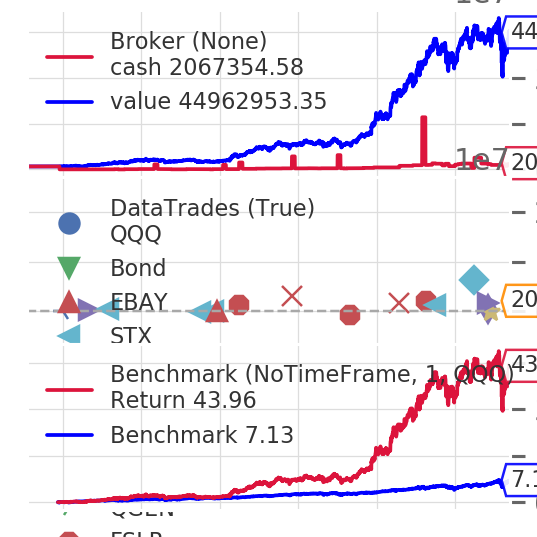

Sortino Ratio :  1.6159751394632815
Profit ... or Loss: 43962953.35


<IPython.core.display.Javascript object>


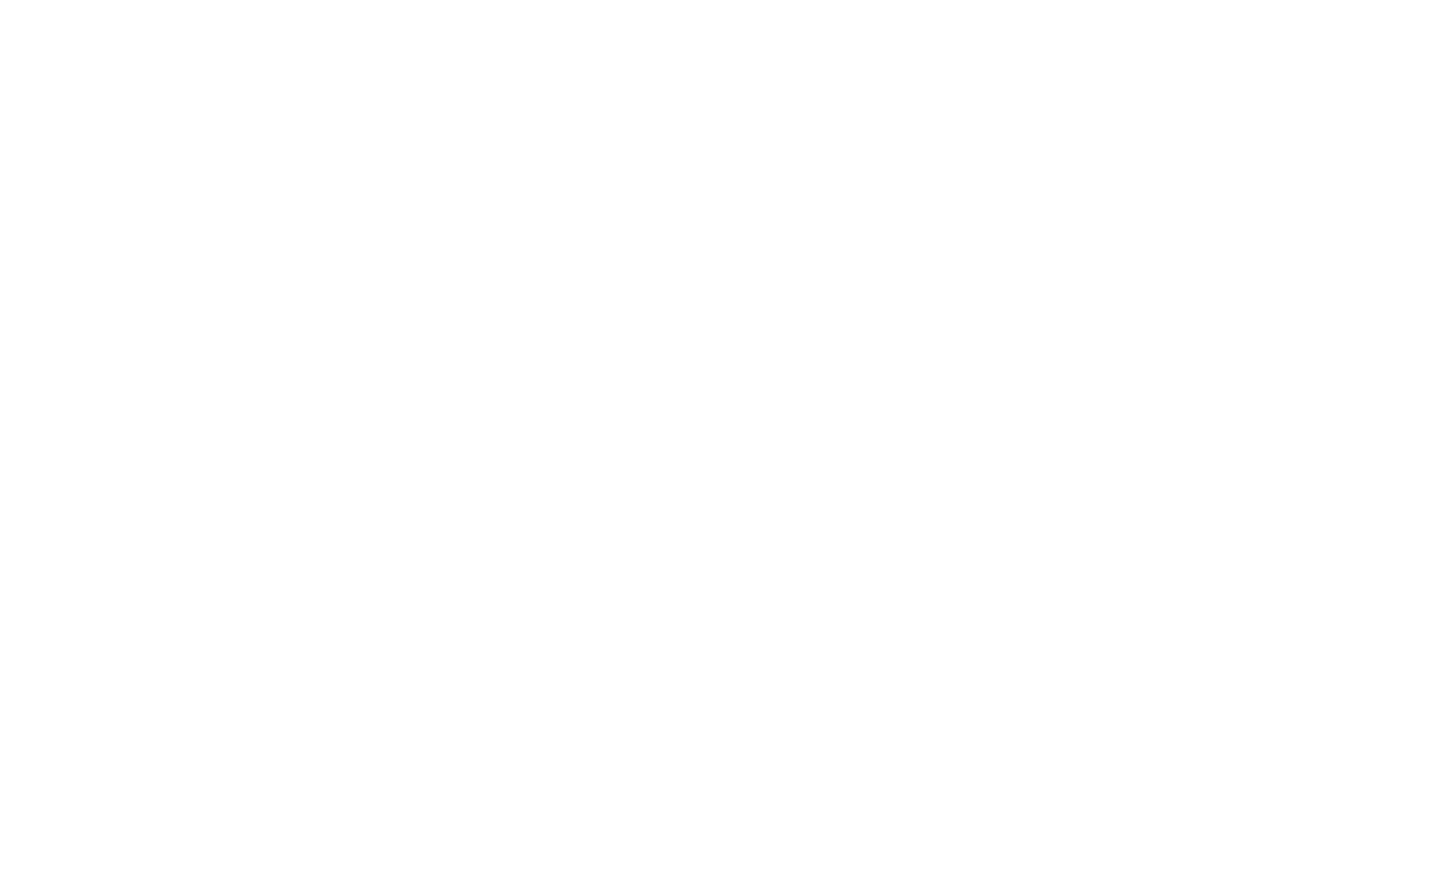

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


<IPython.core.display.Javascript object>


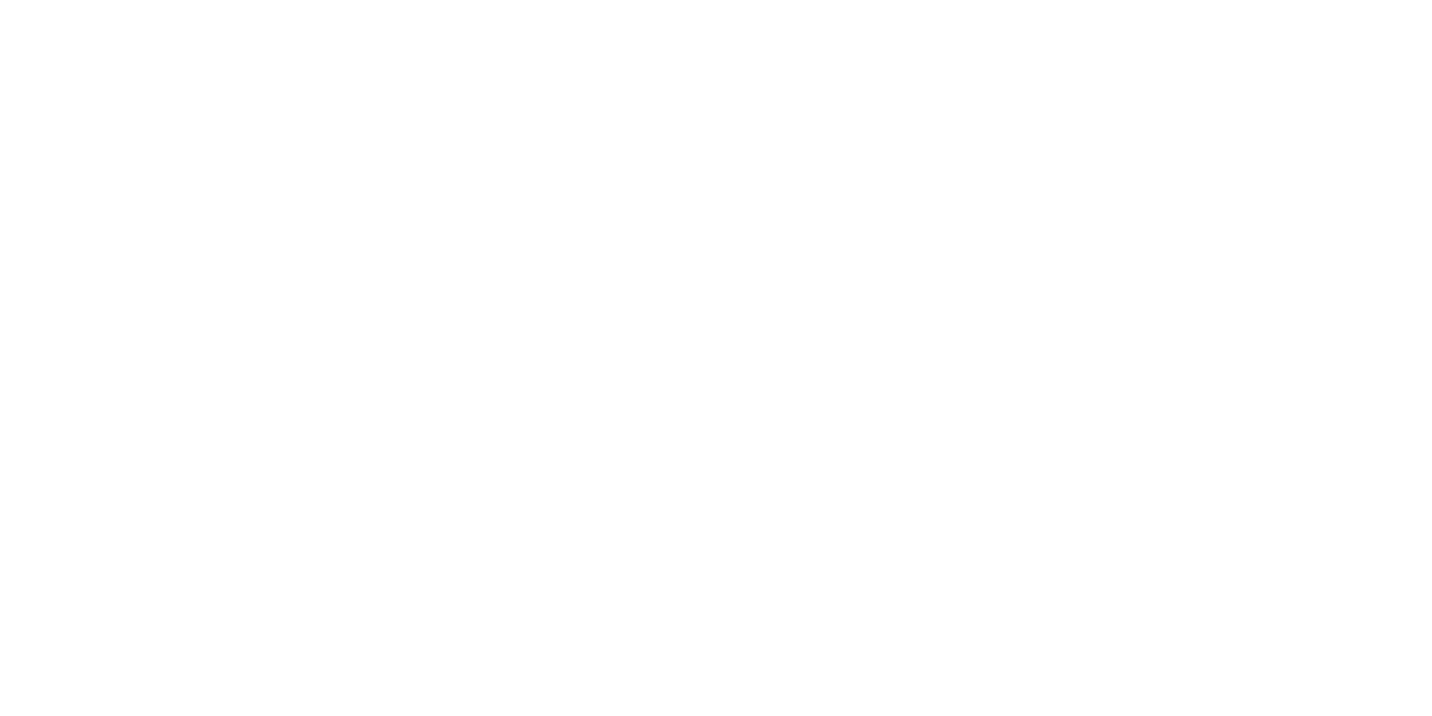

<IPython.core.display.Javascript object>


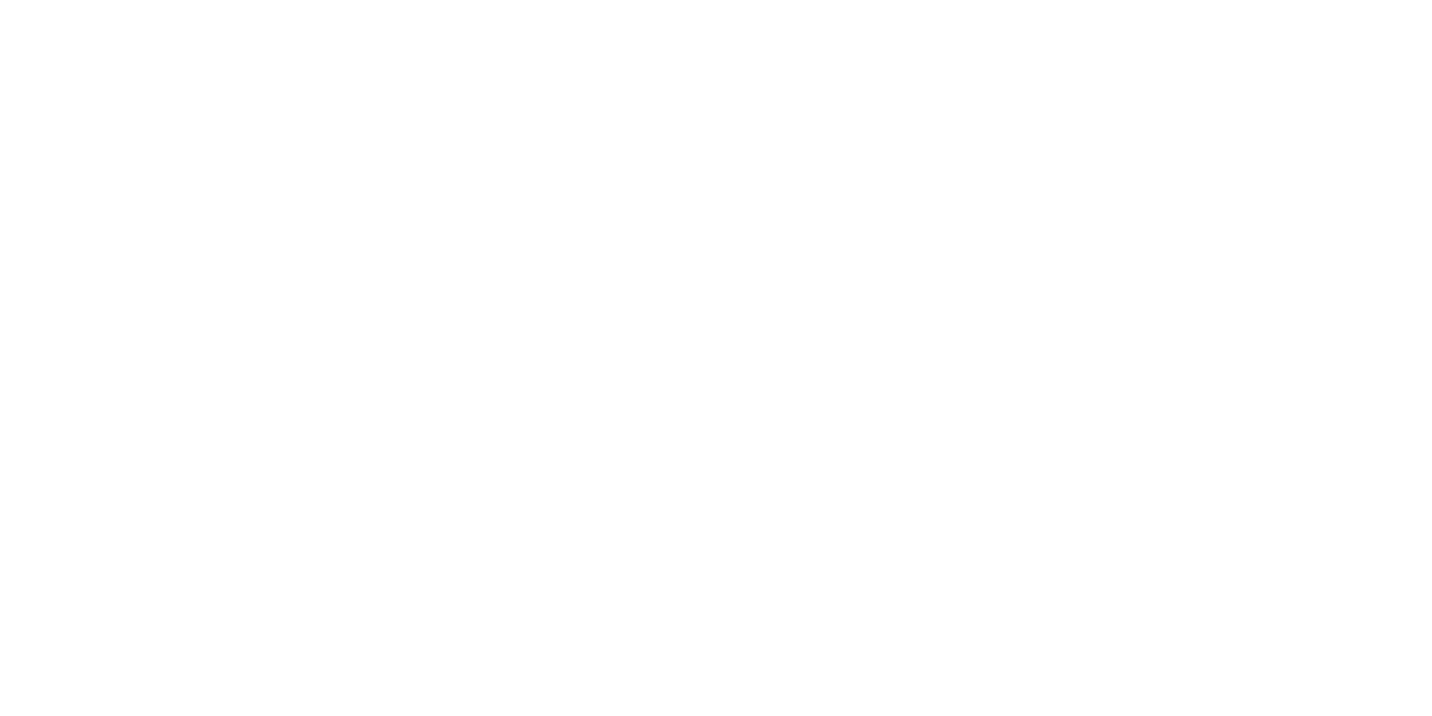

<IPython.core.display.Javascript object>


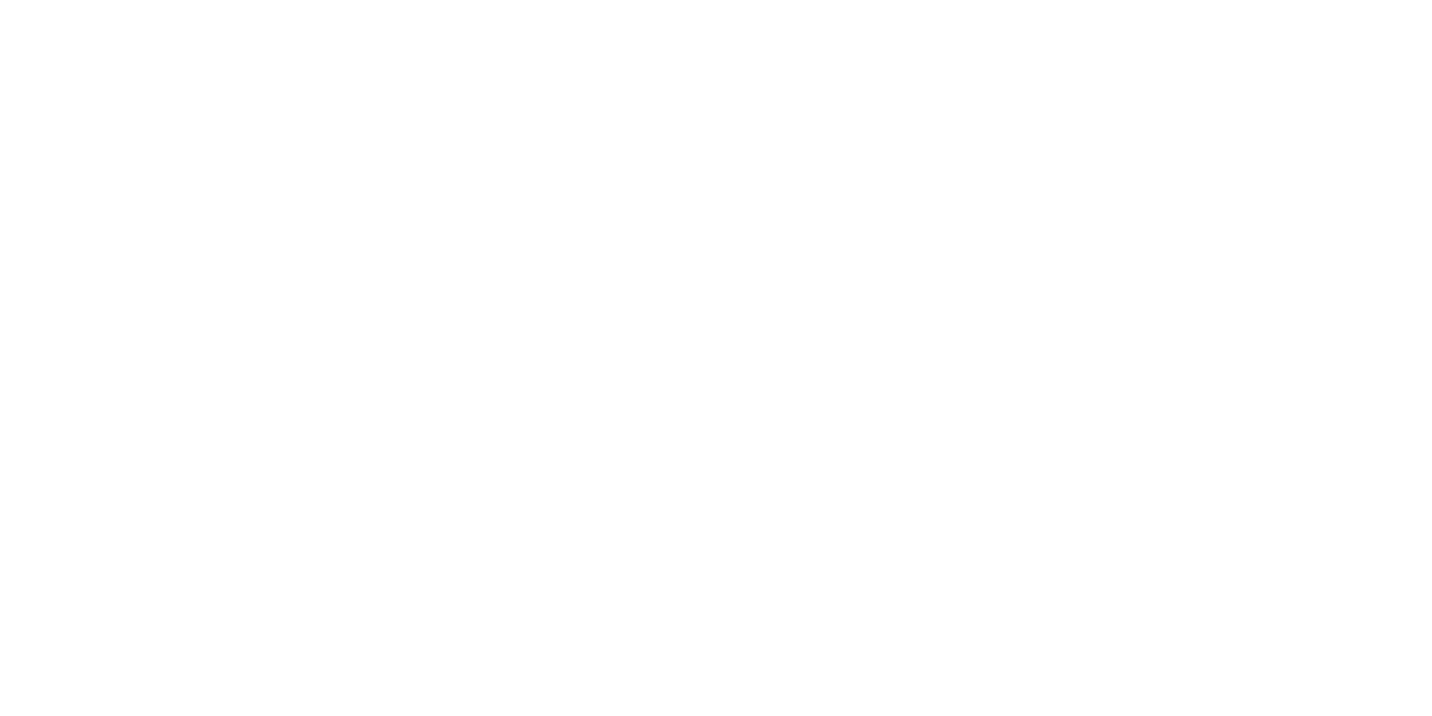

<IPython.core.display.Javascript object>


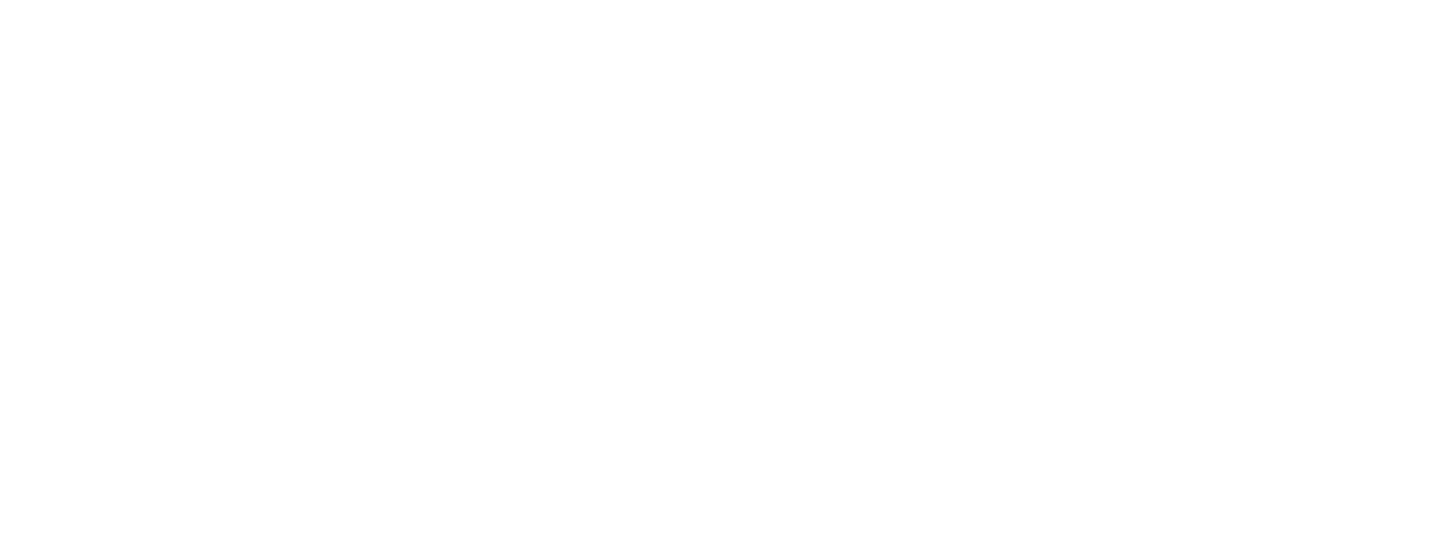

<IPython.core.display.Javascript object>


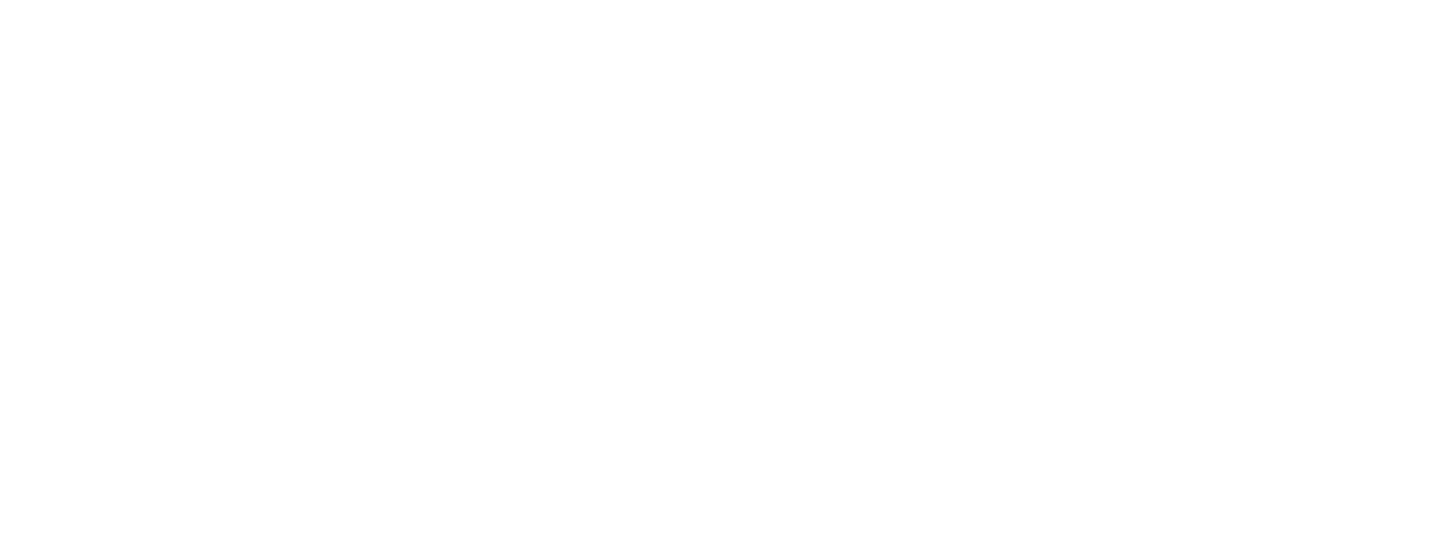

<IPython.core.display.Javascript object>


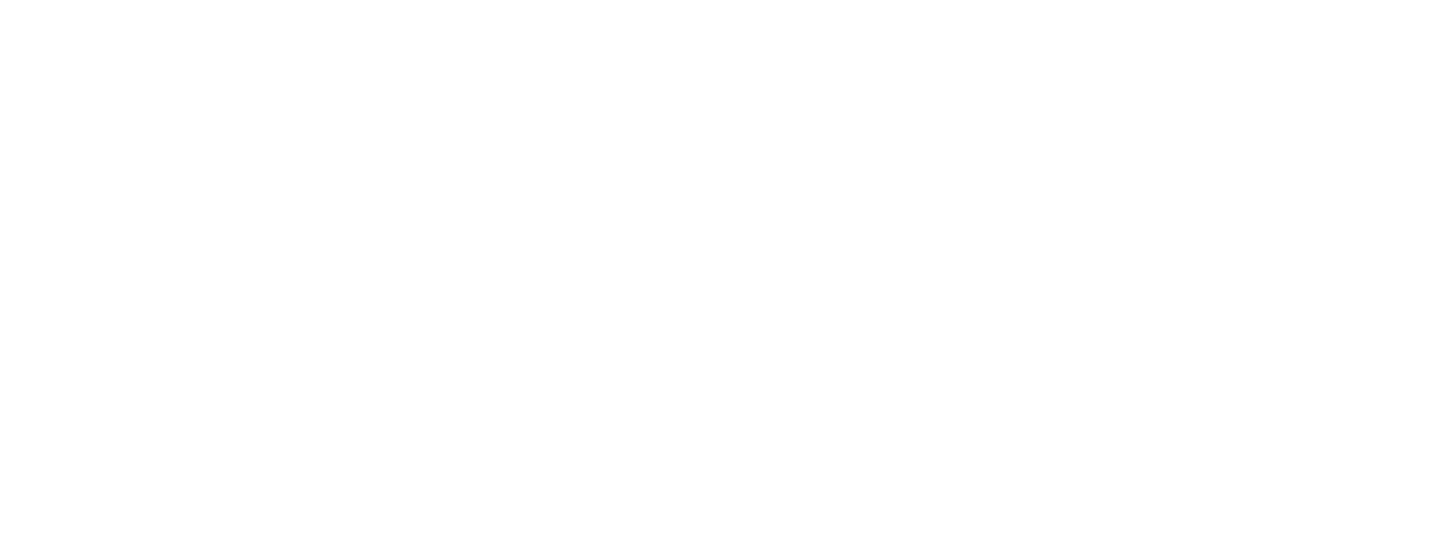

<IPython.core.display.Javascript object>


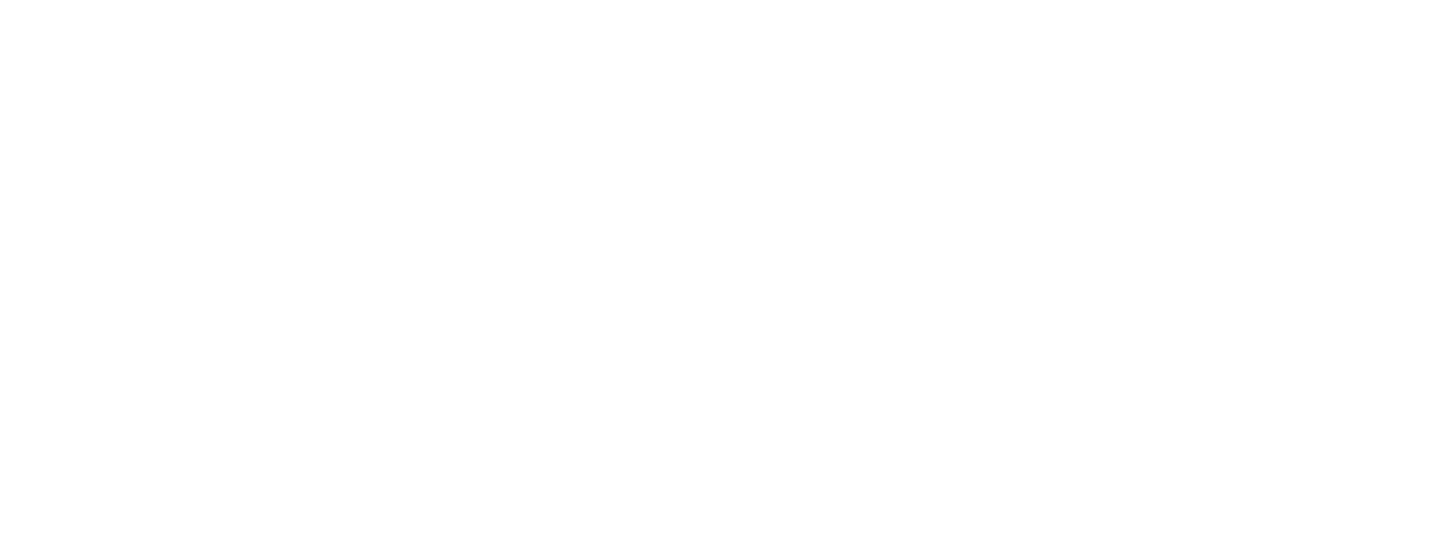

<IPython.core.display.Javascript object>


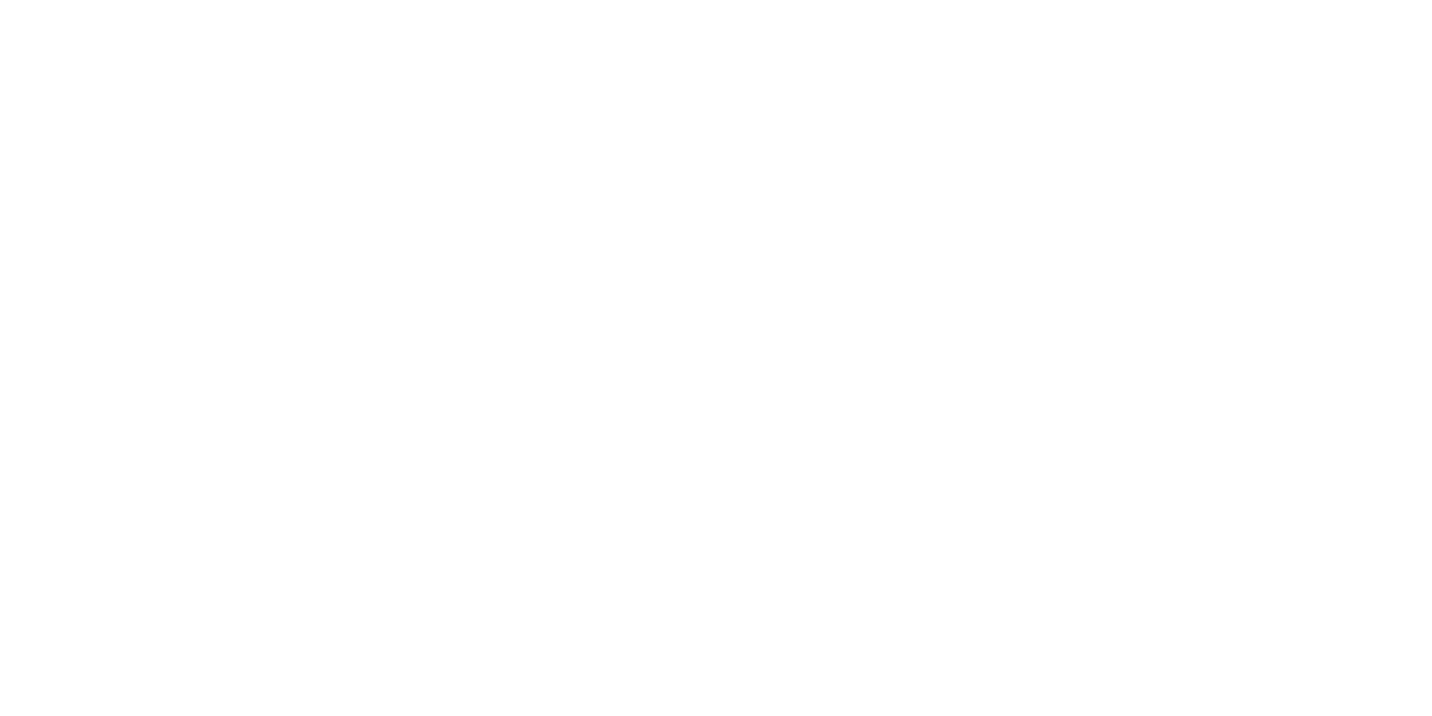

<IPython.core.display.Javascript object>


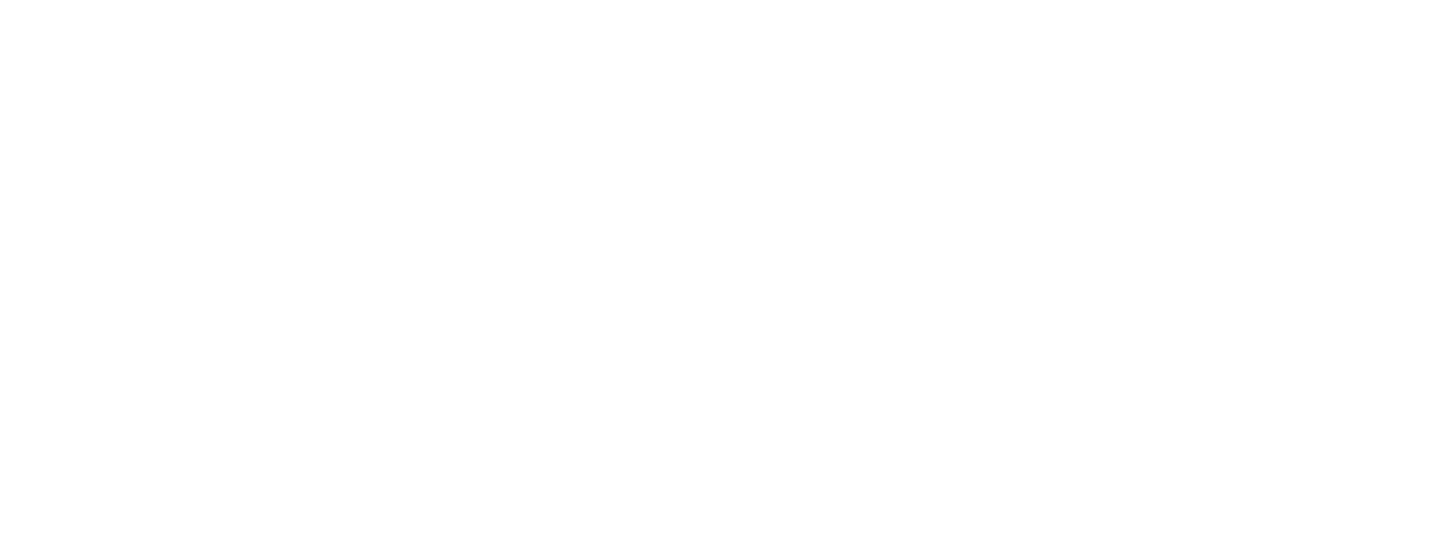

<IPython.core.display.Javascript object>


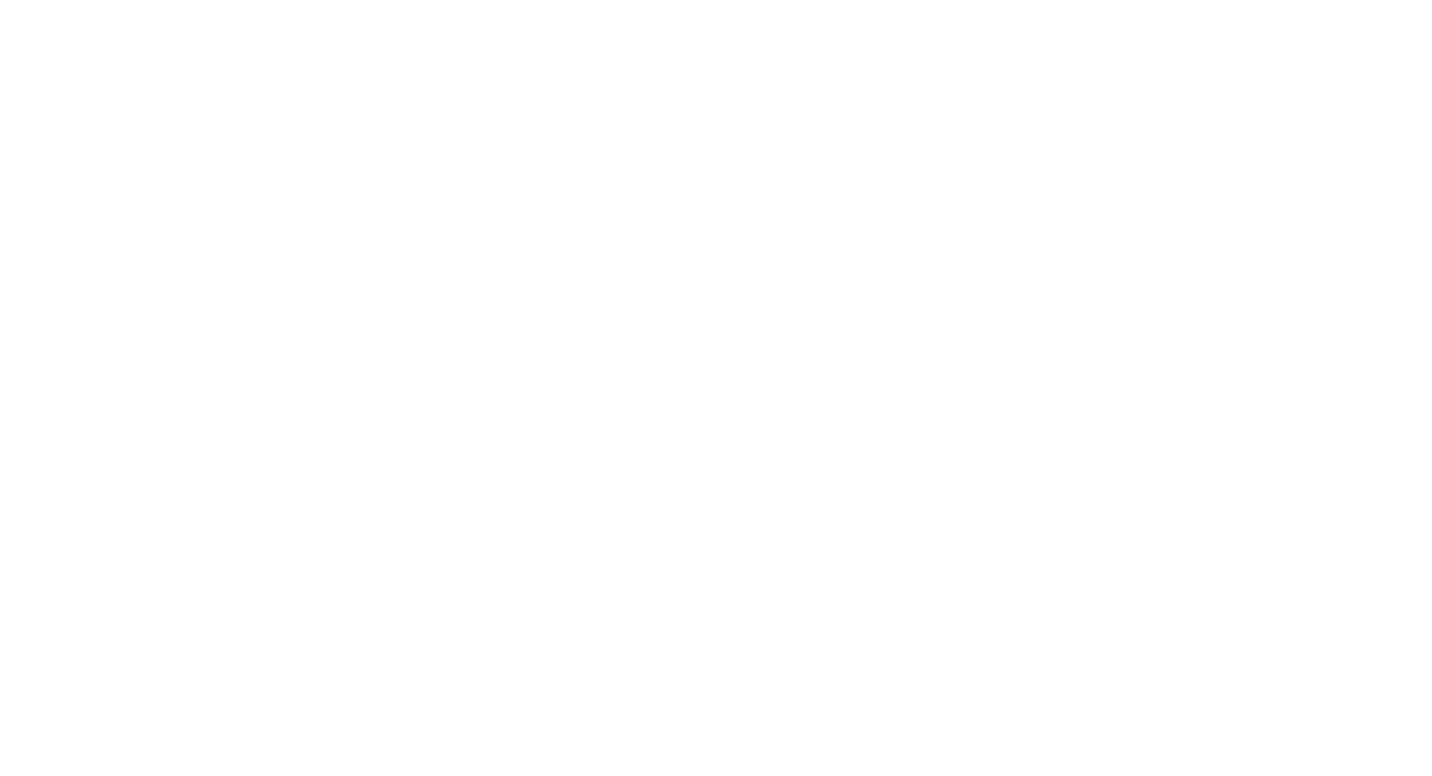

<IPython.core.display.Javascript object>


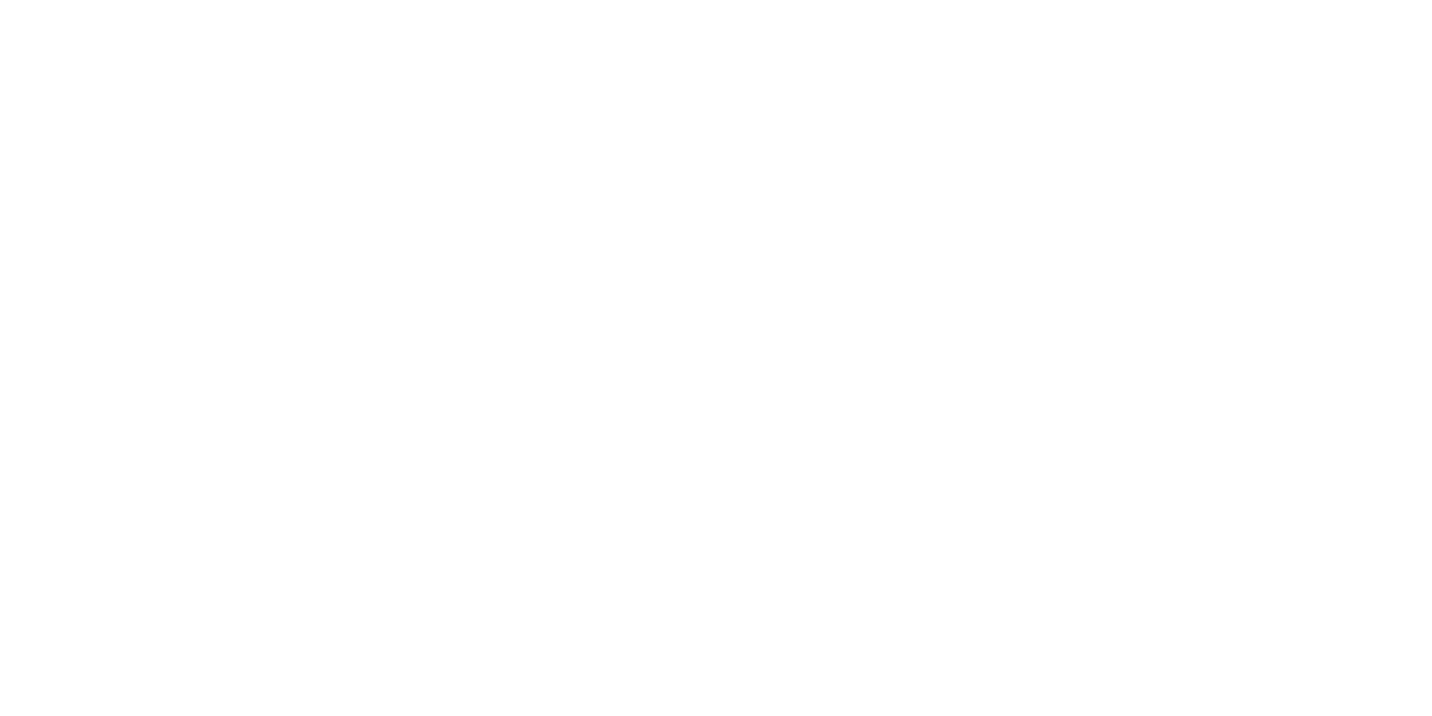

In [12]:
def run(args=None):
    #optreturn=False otherwise the heatmap doesn't work
    cerebro = bt.Cerebro(maxcpus=1,
                         preload=False,
		                 optdatas=False,
		                 optreturn=False,
		                 stdstats=True) 
    
    #plotsize
    plt.rcParams['figure.figsize'] = [3, 3]
    plt.rcParams['figure.dpi'] = 200
        
    # <<<Data loading section>>>
    
    # Parse from/to-date
    fromdate = globalparams["fromdate"]
    todate = globalparams["todate"]
    
    datafeeds = {}
    
    # Add SPY/QQQ as "Benchmark"
    df0 = pd.read_csv('/home/mmd/Data/QQQ.csv', index_col=0, parse_dates=True)
    benchdata = bt.feeds.PandasData(dataname=df0,name="QQQ",fromdate=fromdate, todate=todate,  plot=False)
    cerebro.adddata(benchdata)
    df0 = df0.loc[fromdate : todate]
    datafeeds.update({"QQQ": df0})
    
    # Add TMF as "Bond"
    df1 = pd.read_csv('/home/mmd/Data/TLT.csv', index_col=0, parse_dates=True)
    bonddata = bt.feeds.PandasData(dataname=df1,name="Bond",fromdate=fromdate, todate=todate, plot=False)
    cerebro.adddata(bonddata)
    df1 = df1.loc[fromdate : todate]
    datafeeds.update({"Bond": df1})
    
    
    # add all the data files available in the directory datadir
    for fname in glob.glob(os.path.join(globalparams["path"], '*')):
        df = pd.read_csv(fname, index_col=0, parse_dates=True)
        # Add dataframes to a dictionary for walkforward analysis
        if len(df)>210:
            cerebro.adddata(bt.feeds.PandasData(dataname=df,name=os.path.basename(fname).replace(".csv", ""),fromdate=fromdate, todate=todate, plot=False))
            #print(os.path.basename(fname).replace(".csv", "")) #prints the name of the added csv file
        df = df.loc[fromdate : todate]
        datafeeds.update({os.path.basename(fname).replace(".csv", ""): df})
            
    results_list = []
    # <<<Cerebro loading section>>>
    if globalparams["walk"]:
        walk_forward_analysis(datafeeds)
    else:
        ready_list = []
        def dummy_func(index):
            global ready_list
            ready_list.append(index)
            
        # Optimization by Optunity/Heatmap (must be stated outside of other classes/functions)
        def runstrat(p1=globalparams["selcperc"], p2=globalparams["mperiod"], p3=globalparams["rocperiod"]):
            cerebro = bt.Cerebro(maxcpus=0,stdstats=True)
            cerebro.addstrategy(St, selcperc=p1, mperiod=p2, rocperiod=p3, printlog=False) #change the parameters that should be depicted in heatmap
            cerebro.broker.setcash(globalparams["cash"])
            cerebro.broker.setcommission(commission=globalparams["commission"])
            eval(opta(globalparams["optimization_target"])[0])
            cerebro.adddata(benchdata)
            cerebro.adddata(bonddata)  
            for fname in glob.glob(os.path.join(globalparams["path"], '*')):
                df = pd.read_csv(fname, index_col=0, parse_dates=True)
                if len(df)>200:
                    cerebro.adddata(bt.feeds.PandasData(dataname=df,name=os.path.basename(fname).replace(".csv", ""),fromdate=fromdate, todate=todate, plot=False))        

            cerebro.broker.set_coc(True)
            results1 = cerebro.run()
            #add results to list for heatmap function to process
            #eval(params_comb(globalparams["params_combination"])[1][0])
            #print results
            print(round(p1,0), round(p2,0), round(p3,0), round(eval(opta(globalparams["optimization_target"])[1]),2), round(cerebro.broker.getvalue()/globalparams["cash"],2))

            #the return is as far as I can see just legacy since the line above will be used
            if globalparams["heatmap"]: 
                return [round(p1,0), round(p2,0), round(p3,0), round(eval(opta(globalparams["optimization_target"])[1]),1), round(cerebro.broker.getvalue()/globalparams["cash"],1)]
            if globalparams["optunity"]:
                return round(eval(opta(globalparams["optimization_target"])[1]),2)
            
        #Either use Optunity for quick search of optimum
        if globalparams["optunity"]:
            opt = optunity.maximize(runstrat, num_evals=globalparams["num_eval"], pmap=optunity.pmap, p1=eval(params_comb_optunity(globalparams["params_combination"])[0][0]), 
                                    p2=eval(params_comb_optunity(globalparams["params_combination"])[0][1]), 
                                    p3=eval(params_comb_optunity(globalparams["params_combination"])[0][2]))
            optimal_pars, details, _ = opt
            print('Optimal Parameters:')
            print('selcperc = %.4f' % optimal_pars['p1'])
            print('mperiod = %.4f' % optimal_pars['p2'])
            print('rocperiod = %.4f' % optimal_pars['p3'])


        # or heatmap showing how variables i = (y axis/ p1) and j = (x axis /p2) impact strategy outcome
        if globalparams["heatmap"]:     
            pool = multiprocess.Pool(processes=7, maxtasksperchild=1)  
            noduplicates = []
            runt = 1
            for i in eval(params_comb(globalparams["params_combination"])[0][0]):
                i = int(i)
                for j in eval(params_comb(globalparams["params_combination"])[0][1]):
                    j = int(j)
                    for k in eval(params_comb(globalparams["params_combination"])[0][2]):  
                        k = int(k)
                        if runt == 1:
                            noduplicates.append([i, j, k])
                        else:
                            if [i, j, k] in noduplicates:
                                continue
                            else:
                                noduplicates.append([i, j, k])                            
                        runt += 1
                        
            def Convert(lst):
                lst2 = [["p1","p2","p3"] for x in range(len(lst))]
                res_dct = []
                for x in range(len(lst)):
                    res_dct.append(dict(zip(lst2[x],lst[x])))
                return res_dct
            
            Convert(noduplicates)

            results_list = pool.starmap_async(runstrat, noduplicates,chunksize=1)
            pool.close()            
            pool.join()
            
            #sort list since multiprocessing messes up the order
            results_list = sorted(results_list.get(), key = lambda x:(x[0], x[1], x[2]))
            
            if len(globalparams["params_combination"]) == 2:
                for i in range(len(results_list)):
                    results_list[i].pop(eval(params_comb(globalparams["params_combination"])[1][1]))
                my_heatmap1(results_list)
                for i in range(len(results_list)):
                    results_list[i].pop(2)
                my_heatmap1(results_list)
            else:
                plotly_4d(results_list)
            return

        # add strategy
        if globalparams["optunity"]: #Pick other than Buy and Hold Strategy for optunity optimziation
            cerebro.addstrategy(eval(globalparams["strategy"]), selcperc=optimal_pars['p1'], mperiod=int(optimal_pars['p2']), rocperiod=int(optimal_pars['p3']))
        elif globalparams["strategy"] == "HSt": #Buy and Hold Strategy
            cerebro.addstrategy(HSt, buy_date=globalparams["fromdate"])
        else:    
            cerebro.addstrategy(eval(globalparams["strategy"]))

        # set the cash, cheat on close and commission
        cerebro.broker.setcash(globalparams["cash"])
        cerebro.broker.set_coc(True)
        cerebro.broker.setcommission(commission=globalparams["commission"])

        # Adding Analysers
        #cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0, _name='sharpe')
        #cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
        cerebro.addanalyzer(btanal.PyFolio)                # Needed to use PyFolio & Quanstat
        cerebro.addanalyzer(Sortino, _name="sortino") 
        #cerebro.addanalyzer(btanal.TradeAnalyzer)          # Analyzes individual trades

        # If you want to have all data written into a log file
        #cerebro.addwriter(bt.WriterFile, csv=True, out='log.csv')

        cerebro.addobserver(bt.observers.Benchmark,
                            data=benchdata,
                            timeframe=bt.TimeFrame.NoTimeFrame)

        results = cerebro.run(maxcpus=0)#maxcpu=1 otherwise pickling multiprocessing errors

        # <<<Performance analysing section section>>>
        cerebro.plot()

        # Basic performance evaluation ... final value ... minus starting cash
        pnl = cerebro.broker.get_value() - globalparams["cash"]
        print("Sortino Ratio : ", results[0].analyzers.sortino.get_analysis()["sortino"])
        print('Profit ... or Loss: {:.2f}'.format(pnl))

        # Quantstats thanks to https://algotrading101.com/learn/backtrader-for-backtesting/
        # Does not work with optstrategy
        returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
        returns.index = returns.index.tz_convert(None)
        qs.reports.html(returns, output='stats.html', title='Momentum '+ globalparams["strategy"] + " " + str(int(globalparams["selcperc"])) + " # of stocks picked")
        webbrowser.open('stats.html')

        # Pyfolio if needed
        #returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
        #benchmark_rets = pd.Series([0.00004] * len(returns.index), index=returns.index)     
        #pf.create_full_tear_sheet(returns, positions, transactions, benchmark_rets=benchmark_rets)
    
# <<<Execute starting section>>>    
if __name__ == '__main__':
    #cProfile.run("run()") # speed of all parts of the code
    run()

In [13]:
# how do the single stocks perform over the time frame
r'''
fdate = datetime.datetime(2015, 8, 31)
tdate = datetime.datetime(2020, 6, 18)
for fname in glob.glob(os.path.join(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\DAX', '*')):
    df = pd.read_csv(fname, index_col=0, parse_dates=True)
    a = df.at[fdate,"Close"]
    b = df.at[tdate,"Close"]
    print(b/a-1)
'''

'\nfdate = datetime.datetime(2015, 8, 31)\ntdate = datetime.datetime(2020, 6, 18)\nfor fname in glob.glob(os.path.join(r\'C:\\Users\\MMD\\PycharmProjects\\Trading\\Data Mining\\Data\\DAX\', \'*\')):\n    df = pd.read_csv(fname, index_col=0, parse_dates=True)\n    a = df.at[fdate,"Close"]\n    b = df.at[tdate,"Close"]\n    print(b/a-1)\n'